<a href="https://colab.research.google.com/github/asantos2000/master-degree-santos-anderson/blob/main/code/src/chap_7_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validation

Validation of algorithms and transformation results.

Chap 7. Validação
- Section 7.3 Resultados
    - Section 7.3.2 Algoritmos
        - semmantic annotation
        - nl2sbvr
    - Section 7.3.3 Elementos


## Google colab

In [1]:
%load_ext autoreload
%autoreload 2

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  !rm -rf cfr2sbvr configuration checkpoint
  !git clone https://github.com/asantos2000/master-degree-santos-anderson.git cfr2sbvr
  %pip install -r cfr2sbvr/code/requirements.txt
  !cp -r cfr2sbvr/code/src/configuration .
  !cp -r cfr2sbvr/code/src/checkpoint .
  !cp -r cfr2sbvr/code/config.colab.yaml config.yaml
  DEFAULT_CONFIG_FILE="config.yaml"
else:
  DEFAULT_CONFIG_FILE="../config.yaml"

## Imports

In [2]:
# Standard library imports
from collections import defaultdict
from datetime import datetime
import glob
import json
import pickle
import time
from typing import Any
import os

# Third-party imports
import instructor
import humanize
import jellyfish
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from openai import OpenAI
from scipy.spatial.distance import cosine
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
import xlsxwriter
import openpyxl
from pydantic import BaseModel, Field
from typing import List

# Local application/library-specific imports
import checkpoint.main as checkpoint
from checkpoint.main import (
    normalize_str,
    save_checkpoint,
    restore_checkpoint,
    get_all_checkpoints,
    get_elements_from_checkpoints,
    get_elements_from_true_tables,
    DocumentProcessor,
    Document,
)
import configuration.main as configuration
import logging_setup.main as logging_setup
import token_estimator.main as token_estimator
from token_estimator.main import estimate_tokens
import llm_query.main as llm_query
from llm_query.main import query_instruct_llm
import rules_taxonomy_provider.main as rules_taxonomy_provider
from rules_taxonomy_provider.main import RuleInformationProvider, RulesTemplateProvider

DEV_MODE = True

if DEV_MODE:
    # Development mode
    import importlib

    importlib.reload(configuration)
    importlib.reload(logging_setup)
    importlib.reload(checkpoint)
    importlib.reload(token_estimator)
    importlib.reload(llm_query)
    importlib.reload(rules_taxonomy_provider)

# Ensure plots are displayed inline if using a Jupyter notebook
%matplotlib inline

from IPython.display import display

## Settings

### Configuration

In [3]:
# Load configuration
config = configuration.load_config(DEFAULT_CONFIG_FILE)

### Logging

In [4]:
logger = logging_setup.setting_logging(config["DEFAULT_LOG_DIR"], config["LOG_LEVEL"])

2024-11-30 18:45:29 - INFO - Logging is set up with daily rotation.


## Checkpoints

### Restore the checkpoint

In [5]:
# Restore the checkpoint

# To run after extraction
last_checkpoint = configuration.get_last_filename(
    config["DEFAULT_CHECKPOINT_DIR"], "documents", "json"
)

logger.info(f"{last_checkpoint=}")

config["DEFAULT_CHECKPOINT_FILE"] = last_checkpoint

manager = restore_checkpoint(filename=config["DEFAULT_CHECKPOINT_FILE"])

2024-11-30 18:45:29 - INFO - last_checkpoint='../data/checkpoints/documents-2024-11-29-4.json'
2024-11-30 18:45:29 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-11-29-4.json
2024-11-30 18:45:29 - INFO - Checkpoint restored from ../data/checkpoints/documents-2024-11-29-4.json.


## General functions

In [119]:
def prompt_analysis(raw_data, output_dir):
    # Create a DataFrame from the raw data
    data = pd.DataFrame(raw_data, columns=['filename', 'doc_type', 'elapsed_time', 'usage', 'created', 'model'])

    # Transform 'created' to a human-readable datetime format
    data['created'] = pd.to_datetime(data['created'], unit='s')

    # Extract relevant information from the 'usage' dictionary
    data['completion_tokens'] = data['usage'].apply(lambda x: x['completion_tokens'])
    data['prompt_tokens'] = data['usage'].apply(lambda x: x['prompt_tokens'])
    data['total_tokens'] = data['usage'].apply(lambda x: x['total_tokens'])

    # Define a function to get reference model context length
    def get_reference_model_context_length(model):
        return reference_models.get(model, 128_000)  # Default to 128,000 if model is unknown

    # Define a function to get the price per million tokens
    def get_price_per_million_tokens(model):
        return price_per_million_tokens.get(model, 2.50)  # Default to 2.50 if model is unknown

    # Add context length and price per million tokens columns
    data['reference_context_length'] = data['model'].apply(get_reference_model_context_length)
    data['price_per_million_tokens'] = data['model'].apply(get_price_per_million_tokens)

    # Overall Statistics
    total_tokens = data['total_tokens'].sum()
    num_samples = len(data)
    average_elapsed_time = data['elapsed_time'].mean()
    estimated_cost = (data['total_tokens'] / 1_000_000 * data['price_per_million_tokens']).sum()
    average_percentage_context_length = (data['total_tokens'] / data['reference_context_length']).mean() * 100
    min_created = data['created'].min().strftime('%Y-%m-%d %H:%M:%S')
    max_created = data['created'].max().strftime('%Y-%m-%d %H:%M:%S')

    # Add filename column to each statistic for origin tracking
    filename = file_info['filename']
    # Data and time of the execution
    now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Create Overall Statistics DataFrame
    overall_stats_df = pd.DataFrame([{
        'Total Tokens': total_tokens,
        'Number of Samples': num_samples,
        'Average Elapsed Time (s)': average_elapsed_time,
        'Estimated Cost (USD)': estimated_cost,
        'Average Percentage of Context Length (%)': average_percentage_context_length,
        'Min Created Timestamp': min_created,
        'Max Created Timestamp': max_created,
        'origin': filename,
        'run_at': now
    }])

    # Statistics by Sample Type (doc_type)
    stats_by_doc_type = data.groupby('doc_type').agg(
        total_tokens=('total_tokens', 'sum'),
        num_samples=('doc_type', 'count'),
        average_elapsed_time=('elapsed_time', 'mean'),
        average_tokens=('total_tokens', 'mean'),
        estimated_cost=('total_tokens', lambda x: (x.sum() / 1_000_000) * data.loc[x.index, 'price_per_million_tokens'].mean()),
        average_percentage_context_length=('total_tokens', lambda x: (x.mean() / data.loc[x.index, 'reference_context_length'].mean()) * 100)
    ).reset_index()
    stats_by_doc_type['filename'] = filename
    stats_by_doc_type['run_at'] = now

    # Statistics by Model
    stats_by_model = data.groupby('model').agg(
        total_tokens=('total_tokens', 'sum'),
        num_samples=('model', 'count'),
        average_elapsed_time=('elapsed_time', 'mean'),
        average_tokens=('total_tokens', 'mean'),
        average_percentage_context_length=('total_tokens', lambda x: (x.mean() / get_reference_model_context_length(x.name)) * 100)
    ).reset_index()
    stats_by_model['filename'] = filename
    stats_by_model['run_at'] = now

    # Add estimated cost and cost columns separately since they require different calculations
    def calculate_group_cost(model):
        price = get_price_per_million_tokens(model)
        total_tokens = data[data['model'] == model]['total_tokens'].sum()
        return (total_tokens / 1_000_000) * price

    stats_by_model['estimated_cost'] = stats_by_model['model'].apply(calculate_group_cost)
    stats_by_model['cost'] = stats_by_model['estimated_cost']

    # Calculate Tokens per Second
    # Ensure there are no division by zero issues by filtering out zero elapsed times
    data = data[data['elapsed_time'] > 0]
    data['tokens_per_second'] = data['total_tokens'] / data['elapsed_time']

    # Write the statistics to an Excel file
    file_name = os.path.join(output_dir, 'prompt-analysis.xlsx')

    with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
        # Replace the data on each sheet with the new data
        overall_stats_df.to_excel(writer, sheet_name='Overall Statistics', index=False)
        stats_by_doc_type.to_excel(writer, sheet_name='Statistics by Sample Type', index=False)
        stats_by_model.to_excel(writer, sheet_name='Statistics by Model', index=False)
        additional_stats_df = pd.DataFrame([{
            'Average Completion Tokens': data['completion_tokens'].mean(),
            'Average Prompt Tokens': data['prompt_tokens'].mean(),
            'Average Total Tokens per Sample': data['total_tokens'].mean(),
            'Total Elapsed Time (s)': data['elapsed_time'].sum(),
            'Average Tokens per Second': data['tokens_per_second'].mean(),
            'origin': filename,
            'run_at': now
        }])
        additional_stats_df.to_excel(writer, sheet_name='Additional Statistics', index=False)
        data.to_excel(writer, sheet_name='Raw Data', index=False)

        # Explanation Page
        explanation_data = {
            'Sheet Name': ['Overall Statistics', 'Statistics by Sample Type', 'Statistics by Model', 'Additional Statistics', 'Raw Data'],
            'Description': [
                'Summary statistics of the entire dataset, including total tokens, number of samples, average elapsed time, and estimated cost.',
                'Statistics broken down by sample type (doc_type), including the total number of tokens and cost estimates for each type.',
                'Statistics grouped by the model used, showing token utilization, cost, and elapsed time for each model.',
                'Additional aggregated metrics such as average completion tokens, prompt tokens, total tokens per sample, and processing time.',
                'The raw data used for generating all the statistics, including individual completions and their details.'
            ],
            'Columns Explained': [
                'Total Tokens: Total number of tokens processed. Number of Samples: Total number of samples. Average Elapsed Time (s): Average time taken for processing. Estimated Cost (USD): Estimated cost for token usage. Average Percentage of Context Length (%): Average percentage of used context length. Min and Max Created Timestamp: The time range of the data collected. Origin: Source filename.',
                'doc_type: Type of document. total_tokens: Sum of tokens per document type. num_samples: Number of samples of this type. average_elapsed_time: Average time taken per document type. average_tokens: Average tokens per sample. estimated_cost: Estimated cost for tokens of this type. average_percentage_context_length: Average percentage of context length used. filename: Source filename.',
                'model: Model name. total_tokens: Total number of tokens used by the model. num_samples: Number of samples processed by the model. average_elapsed_time: Average processing time for the model. average_tokens: Average number of tokens per sample. average_percentage_context_length: Average context length percentage used. filename: Source filename. estimated_cost/cost: Cost for the tokens used by the model.',
                'Average Completion Tokens: Average number of completion tokens per sample. Average Prompt Tokens: Average number of prompt tokens per sample. Average Total Tokens per Sample: Average number of total tokens per sample. Total Elapsed Time (s): Total processing time for all samples. Average Tokens per Second: Average number of tokens processed per second. origin: Source filename.',
                'filename: Source filename. doc_type: Type of document. elapsed_time: Time taken for each document. usage: Token usage details (completion and prompt). created: Timestamp of creation. model: Model used.'
            ]
        }
        explanation_df = pd.DataFrame(explanation_data)
        explanation_df.to_excel(writer, sheet_name='Explanation', index=False)

    # Display Overall Statistics
    overall_stats_df_display = pd.DataFrame([{
        'Total Tokens': total_tokens,
        'Number of Samples': num_samples,
        'Average Elapsed Time (s)': average_elapsed_time,
        'Estimated Cost (USD)': estimated_cost,
        'Average Percentage of Context Length (%)': average_percentage_context_length,
        'Min Created Timestamp': min_created,
        'Max Created Timestamp': max_created,
        'origin': filename,
        'run_at': now
    }])
    print("\nOverall Statistics:")
    print(overall_stats_df_display.to_string(index=False))

    # Display Statistics by Sample Type
    print("\nStatistics by Sample Type (doc_type):")
    print(stats_by_doc_type.to_string(index=False))

    # Display Statistics by Model
    print("\nStatistics by Model:")
    print(stats_by_model.to_string(index=False))

    # Additional Statistics
    additional_stats_df_display = pd.DataFrame([{
        'Average Completion Tokens': data['completion_tokens'].mean(),
        'Average Prompt Tokens': data['prompt_tokens'].mean(),
        'Average Total Tokens per Sample': data['total_tokens'].mean(),
        'Total Elapsed Time (s)': data['elapsed_time'].sum(),
        'Average Tokens per Second': data['tokens_per_second'].mean(),
        'origin': filename,
        'run_at': now
    }])
    print("\nAdditional Statistics:")
    print(additional_stats_df_display.to_string(index=False))


In [7]:
def get_pred_terms(checkpoint_dir):
    """
    Get predicted terms from checkpoints.

    Args:
        checkpoint_dir: Directory containing checkpoints.

    Returns:
        List of predicted terms.
    """
    managers, file_info_list = get_all_checkpoints(checkpoint_dir)

    logger.info(f"Loaded {len(managers)} checkpoints")
    
    pred_terms = {}

    for manager, file_info in zip(managers, file_info_list):
        docs_ids = manager.list_document_ids(doc_type="llm_response")

        for doc_id in docs_ids:
            if doc_id.startswith("§") and doc_id.endswith("_P2"):
                doc = manager.retrieve_document(doc_id, "llm_response")
                logger.debug(f"{doc_id=}, {doc=}")
                
                terms = {}
                for term in doc.content.get("terms"):
                    logger.debug(f"{term=}")
                    signifier = term.get("term", "")
                    definition = term.get("definition", None)  # Definition can be null
                    terms[signifier] = {
                        "definition": definition,
                        "from_filename": file_info["filename"],
                    }
                pred_terms[doc_id.replace("_P2", "")] = terms

        logger.info(f"Count: {len(pred_terms)} documents")

    return pred_terms

In [8]:
def summarize_terms(terms, name):
    """
    Summarize the terms in the P2 dictionary.

    Args:
        terms (dict): A dictionary of terms.
        name (str): The name of the terms.

    Returns:
        None
    """
    logger.info(f"{name} docs: {len(terms)}")
    total = 0
    for key in terms.keys():
        num = len(terms[key])
        logger.info(f"{key=}: {num=}")
        total += num
    logger.info(f"Total {name}: {total}")

In [9]:
def get_true_terms(manager):
    """
    Read the true terms from the true tables.

    Args:
        manager (DocumentManager): The DocumentManager instance.

    Returns:
        list: A list of true terms.
    """
    docs_ids = manager.list_document_ids()

    true_terms = {}

    for doc_id in docs_ids:
        if doc_id.startswith("§") and doc_id.endswith("_P2"):
            doc = manager.retrieve_document(doc_id, "true_table")
            logger.debug(f"{doc_id=}, {doc=}")
            
            terms = {}
            for term in doc.content.get("terms"):
                logger.debug(f"{term=}")
                signifier = term.get("term", "")
                definition = term.get("definition", None)  # Definition can be null
                terms[signifier] = {
                    "definition": definition,
                }
            true_terms[doc_id.replace("_P2", "")] = terms

    logger.info(f"Count: {len(true_terms)} documents")

    return true_terms

In [10]:
def get_pred_elements(checkpoint_dir):
    """
    Get predicted elements from checkpoints.

    Args:
        checkpoint_dir: Directory containing checkpoints.

    Returns:
        List of predicted elements.
    """
    managers, file_info_list = get_all_checkpoints(checkpoint_dir)

    logger.info(f"Loaded {len(managers)} checkpoints")
    
    pred_elements = []

    for manager, file_info in zip(managers, file_info_list):
        docs_ids = manager.list_document_ids(doc_type="llm_response")

        logger.info(f"Processing {len(docs_ids)}, {docs_ids=} documents from {file_info=}")

        for doc_id in docs_ids:
            if doc_id.startswith("§") and doc_id.endswith("_P1"):
                logger.info(f"Processing {doc_id}")
                doc = manager.retrieve_document(doc_id, "llm_response")
                logger.debug(f"{doc_id=}")

                for element in doc.content.get("elements"):
                    logger.debug(f'{element.get("id")=}')
                    pred_elements.append(
                        {
                            "doc_id": doc.id.replace("_P1", ""),
                            "id": element.get("id"),
                            "statement": element.get("statement"),
                            "classification": element["classification"],
                            "source": f'{doc.content.get("section")}{element.get("source")}',
                            "filename": file_info.get("filename"),
                        }
                    )
            else:
                logger.info(f"Skipping {doc_id}")

        logger.info(f"Toal of elements: {len(pred_elements)}")
    
    logger.info("Processed all documents")
    
    return pred_elements

In [11]:
def get_true_elements(manager):
    """
    Read the true elements from the true tables.

    Args:
        manager (DocumentManager): The DocumentManager instance.

    Returns:
        list: A list of true elements.
    """
    docs_ids = manager.list_document_ids(doc_type="true_table")

    true_elements = []

    for doc_id in docs_ids:
        if doc_id.startswith("§") and doc_id.endswith("_P1"):
            doc = manager.retrieve_document(doc_id, "true_table")
            logger.debug(f"{doc_id=}, {doc=}")

            for element in doc.content.get("elements"):
                true_elements.append(
                    {
                        "doc_id": doc.id.replace("_P1", ""),
                        "id": element.get("id"),
                        "statement": element.get("statement"),
                        "classification": element["classification"],
                        "source": f'{doc.content.get("section")}{element.get("source")}',
                    }
                )

    logger.info(f"Count: {len(true_elements)} elements")

    return true_elements

In [12]:
# Function to group statements by doc_id
def group_statements_by_doc_id(statements_list, is_pred=False):
    doc_id_map = defaultdict(list)
    for item in statements_list:
        doc_id = item["doc_id"]
        if is_pred:
            # Include filename, id, and classification for pred_list items
            statement_info = {
                "id": item["id"],
                "statement": item["statement"],
                "classification_pred": item.get("classification", None),
                "source_pred": item["source"],
                "filename_pred": item["filename"],
            }
        else:
            # Include id and classification for true_list items
            statement_info = {
                "id": item["id"],
                "statement": item["statement"],
                "classification_true": item.get("classification", None),
                "source_true": item["source"],
            }
        doc_id_map[doc_id].append(statement_info)

    logger.debug(f"doc_id_map: {doc_id_map}")

    return doc_id_map


# Function to check the similarity between true and pred statements grouped by doc_id
def check_for_statements_similarity(true_list, pred_list, threshold=0.7):
    # Build mappings from doc_id to list of statements
    true_statements_by_doc_id = group_statements_by_doc_id(true_list)
    pred_statements_by_doc_id = group_statements_by_doc_id(pred_list, is_pred=True)

    results = []
    all_doc_ids = set(true_statements_by_doc_id.keys()).union(
        pred_statements_by_doc_id.keys()
    )

    for doc_id in all_doc_ids:
        true_statements = true_statements_by_doc_id.get(doc_id, [])
        pred_statements = pred_statements_by_doc_id.get(doc_id, [])

        for pred_item in pred_statements:
            pred_expr = pred_item["statement"]
            pred_id = pred_item["id"]
            classification_pred = pred_item.get("classification_pred", None)
            source_pred = pred_item["source_pred"]
            filename_pred = pred_item["filename_pred"]

            best_match = None
            best_score = 0
            best_true_id = None
            classification_true = None

            for true_item in true_statements:
                true_expr = true_item["statement"]
                true_id = true_item["id"]
                source_true = true_item["source_true"]
                # Calculate the similarity score using the Levenshtein distance
                score = jellyfish.levenshtein_distance(pred_expr, true_expr)
                similarity_score = 1 - (
                    score / max(len(pred_expr), len(true_expr))
                )  # Normalize to a similarity score

                if similarity_score > best_score:
                    best_score = similarity_score
                    best_match = true_expr
                    best_true_id = true_id
                    best_source = source_true
                    classification_true = true_item.get("classification_true", None)
            results.append(
                {
                    "doc_id": doc_id,
                    "id_pred": pred_id,
                    "id_true": best_true_id,
                    "classification_pred": classification_pred,
                    "classification_true": classification_true,
                    "source_pred": source_pred,
                    "source_true": best_source,
                    "filename_pred": filename_pred,
                    "statement_pred": pred_expr,
                    "statement_true": best_match,
                    "similarity_score": best_score,
                }
            )
    return results


# Add similarity_classification based on similarity_score
def classify_similarity(score):
    if score == 1.0:
        return "identical"
    elif score >= 0.9:
        return "close-match"
    else:
        return "not-sure"


# Modify the highlight_similarity function to use three colors
def highlight_similarity(val):
    if val == "identical":
        color = "green"
    elif val == "close-match":
        color = "yellow"
    else:
        color = "red"
    return f"background-color: {color}"

In [13]:
def create_df_elements_results(similarity_elements_results):
    # Build the dataframe
    df_results = pd.DataFrame(similarity_elements_results)

    df_results["similarity_classification"] = df_results["similarity_score"].apply(
        classify_similarity
    )

    df_results["classification_match"] = (
        df_results["classification_pred"] == df_results["classification_true"]
    )
    df_results["classification_match_label"] = df_results["classification_match"].map(
        {True: "match", False: "mismatch"}
    )

    df_results["source_match"] = df_results["source_pred"] == df_results["source_true"]
    df_results["source_match_label"] = df_results["source_match"].map(
        {True: "match", False: "mismatch"}
    )

    df_results["id_match"] = df_results["id_pred"] == df_results["id_true"]
    df_results["id_match_label"] = df_results["id_match"].map(
        {True: "match", False: "mismatch"}
    )

    return df_results

In [14]:
def create_df_elements_results_confusion_matrix_classification(df_elements_results):
    # Prepare the data
    df_elements_evaluation = df_elements_results.dropna(
        subset=["classification_true", "classification_pred"]
    )

    y_true = df_elements_evaluation["classification_true"]
    y_pred = df_elements_evaluation["classification_pred"]

    # Get the unique labels from both y_true and y_pred
    labels = np.unique(np.concatenate((y_true.unique(), y_pred.unique())))

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Create a ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format="d")
    plt.title("Matrix de confusão para classificação")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Generate the classification report
    report = classification_report(y_true, y_pred, labels=labels, digits=4)
    print("Classification Report:\n")
    print(report)

In [15]:
def create_elements_results_distribution_similarity(df_elements_results):
    # Assuming you already have similarity_counts
    similarity_elements_counts = df_elements_results[
        "similarity_classification"
    ].value_counts()

    # Calculating the total number of classifications
    total_counts = similarity_elements_counts.sum()

    # Plotting the distribution
    fig, ax = plt.subplots(
        figsize=(10, 6)
    )  # Increase the figure size for better visibility
    ax = similarity_elements_counts.plot(
        kind="bar", color=["green", "yellow", "blue"], edgecolor="black"
    )

    # Adding chart title and axis labels
    plt.title("Distribuição de Classificações de Similaridade", fontsize=16)
    plt.xlabel("Classificações de Similaridade", fontsize=14)
    plt.ylabel("Contagem", fontsize=14)

    # Adding count and percentage on each bar in the same line
    for p in ax.patches:
        count = p.get_height()
        percentage = count / total_counts * 100
        ax.annotate(
            f"{count} ({percentage:.1f}%)",
            (
                p.get_x() + p.get_width() / 2.0,
                count,
            ),  # Position slightly above the bar for clarity
            ha="center",
            va="bottom",
            fontsize=12,
            color="black",
        )

    # Optimizing axes labels and tick sizes
    plt.xticks(rotation=45, fontsize=12)  # Rotate x labels for better readability
    plt.yticks(fontsize=12)

    # Adding grid lines for better visual reference
    plt.grid(axis="y", linestyle="--", linewidth=0.3)

    plt.tight_layout()  # Adjust the padding for cleaner look
    plt.show()

In [16]:
def create_df_elements_results_confusion_matrix_source(df_elements_results):
    # Prepare the data
    df_elements_evaluation = df_elements_results.dropna(
        subset=["source_true", "source_pred"]
    )

    y_true = df_elements_evaluation["source_true"]
    y_pred = df_elements_evaluation["source_pred"]

    # Get the unique labels from both y_true and y_pred
    labels = np.unique(np.concatenate((y_true.unique(), y_pred.unique())))

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Create a ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format="d")
    plt.title("Matrix de confusão para origem")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Generate the classification report
    report = classification_report(y_true, y_pred, labels=labels, digits=4)
    print("Classification Report:\n")
    print(report)

In [17]:
def create_elements_results_distribution_source(df_elements_results):
    # Assuming you already have similarity_counts
    similarity_elements_counts = df_elements_results["source_match"].value_counts()

    # Calculating the total number of classifications
    total_counts = similarity_elements_counts.sum()

    # Plotting the distribution
    fig, ax = plt.subplots(
        figsize=(10, 6)
    )  # Increase the figure size for better visibility
    ax = similarity_elements_counts.plot(
        kind="bar", color=["green", "red"], edgecolor="black"
    )

    # Adding chart title and axis labels
    plt.title("Distribuição de Classificações de origem", fontsize=16)
    plt.xlabel("Classificações de origem", fontsize=14)
    plt.ylabel("Contagem", fontsize=14)

    # Adding count and percentage on each bar in the same line
    for p in ax.patches:
        count = p.get_height()
        percentage = count / total_counts * 100
        ax.annotate(
            f"{count} ({percentage:.1f}%)",
            (
                p.get_x() + p.get_width() / 2.0,
                count,
            ),  # Position slightly above the bar for clarity
            ha="center",
            va="bottom",
            fontsize=12,
            color="black",
        )

    # Optimizing axes labels and tick sizes
    plt.xticks(rotation=45, fontsize=12)  # Rotate x labels for better readability
    plt.yticks(fontsize=12)

    # Adding grid lines for better visual reference
    plt.grid(axis="y", linestyle="--", linewidth=0.3)

    plt.tight_layout()  # Adjust the padding for cleaner look
    plt.show()

In [18]:
# Function to check the similarity between true and pred definitions using term IDs
def check_for_definitions_similarity(true_terms, pred_terms):
    results = []
    total_terms = 0  # Total number of terms in true_terms
    matched_terms = 0  # Number of terms that have a matching term in pred_terms

    # Only iterate over doc_ids present in true_terms
    for doc_id, true_doc_terms in true_terms.items():
        pred_doc_terms = pred_terms.get(doc_id, {})

        # Iterate over terms present in true_doc_terms
        for term_id, true_item in true_doc_terms.items():
            total_terms += 1  # Count the total number of terms in true_terms
            pred_item = pred_doc_terms.get(term_id)

            if pred_item is None:
                # Term exists in true terms but not in predictions
                results.append(
                    {
                        "doc_id": doc_id,
                        "term": term_id,
                        "definition_pred": "",
                        "definition_true": true_item["definition"] or "",
                        "similarity_score": 0,
                    }
                )
            else:
                matched_terms += 1  # Increment the matched terms count
                # Both true and pred definitions exist for this term
                pred_def = pred_item["definition"] or ""
                true_def = true_item["definition"] or ""

                # Ensure definitions are strings
                pred_def = str(pred_def)
                true_def = str(true_def)

                # Compute similarity
                score = jellyfish.levenshtein_distance(pred_def, true_def)
                max_length = max(
                    len(pred_def), len(true_def), 1
                )  # Avoid division by zero
                similarity_score = 1 - (score / max_length)

                results.append(
                    {
                        "doc_id": doc_id,
                        "term": term_id,
                        "definition_pred": pred_def,
                        "definition_true": true_def,
                        "similarity_score": similarity_score,
                    }
                )
    # Print the counts of total terms and matched terms
    print(f"Total terms in true_terms: {total_terms}")
    print(f"Total matched terms in pred_terms: {matched_terms}")
    return results

In [19]:
# Highlight differences in Similarity Scores in the DataFrame
def highlight_differences(row):
    if row["similarity_score"] <= 0.8:
        return ["background-color: yellow"] * len(row)
    elif row["similarity_score"] <= 0.5:
        return ["background-color: red"] * len(row)
    else:
        return ["background-color: black"] * len(row)

In [20]:
def create_df_terms_results(similarity_terms_results):
    # Step 1: Load similarity_results into a DataFrame
    df_terms_results = pd.DataFrame(similarity_terms_results)

    return df_terms_results

In [21]:
def create_terms_results_distribution_similarity(df_terms_results):
    # Plot a Histogram of Similarity Scores
    plt.figure(figsize=(10, 6))
    plt.hist(
        df_terms_results["similarity_score"],
        bins=20,
        edgecolor="black",
        color="skyblue",
    )
    plt.xlabel("Similarity Score")
    plt.ylabel("Number of Terms")
    plt.title("Distribution of Similarity Scores")
    plt.grid(axis="y")
    plt.show()

In [22]:
def create_terms_results_histogram_low_similarity(df_terms_results, number_of_terms=10):
    df_low_similarity = df_terms_results.sort_values(by="similarity_score").head(
        number_of_terms
    )

    plt.figure(figsize=(12, 6))
    plt.barh(
        df_low_similarity["term"], df_low_similarity["similarity_score"], color="salmon"
    )
    plt.xlabel("Similarity Score")
    plt.ylabel("Term")
    plt.title("Terms with Lowest Similarity Scores")
    plt.gca().invert_yaxis()  # Invert y-axis to have the lowest score at the top
    plt.show()

In [23]:
def create_terms_results_average_similarity_per_document(df_terms_results):
    doc_similarity = (
        df_terms_results.groupby("doc_id")["similarity_score"].mean().reset_index()
    )

    print("Average Similarity Score per Document:")
    display(doc_similarity)

    # Plot average similarity score per document
    plt.figure(figsize=(12, 6))
    plt.bar(
        doc_similarity["doc_id"], doc_similarity["similarity_score"], color="skyblue"
    )
    plt.xlabel("Document ID")
    plt.ylabel("Average Similarity Score")
    plt.title("Average Similarity Score per Document")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [24]:
def create_terms_results_heatmap(df_terms_results):
    # Pivot the DataFrame to create a matrix of terms vs. documents
    df_pivot = df_terms_results.pivot(
        index="term", columns="doc_id", values="similarity_score"
    )

    # To manage large datasets, you might want to limit the number of terms or documents
    # For example, select the top 50 terms with the most occurrences
    if df_pivot.shape[0] > 50:
        df_pivot = df_pivot.head(50)

    plt.figure(figsize=(12, 10))
    sns.heatmap(df_pivot, cmap="coolwarm", linewidths=0.5)
    plt.title("Heatmap of Similarity Scores")
    plt.xlabel("Document ID")
    plt.ylabel("Term")
    plt.tight_layout()
    plt.show()

In [25]:
def generate_token_estimates_from_checkpoint(last_checkpoint_file):
    # Open last checkpoint
    with open(last_checkpoint_file, "r") as f:
        last_checkpoint = json.load(f)

    # Define sections to process
    sections = ["\u00a7 275.0-2", "\u00a7 275.0-5", "\u00a7 275.0-7"]
    prompts = {
        "extract-P1": last_checkpoint.get("prompt-extract_P1|prompt").get("content"),
        "extract-P2": last_checkpoint.get("prompt-extract_P2|prompt").get("content"),
        # "classify-P2-operative-rule-batch-Party": last_checkpoint.get("prompt-classify_P2_operative_rule_batch1_Party|prompt").get("content"),
        # "classify-P2-operative-rule-batch-Data": last_checkpoint.get("prompt-classify_P2_operative_rule_batch1_Data|prompt").get("content"),
        # "classify-P2-operative-rule-batch-Activity": last_checkpoint.get("prompt-classify_P2_operative_rule_batch1_Activity|prompt").get("content"),
        # "classify-P2-term-batch": last_checkpoint.get("prompt-classify_P2_term_batch1_Definitional|prompt").get("content"),
        # "classify-P2-name-batch": last_checkpoint.get("prompt-classify_P2_name_batch1_Definitional|prompt").get("content"),
        # "classify-P2-fact-type-batch": last_checkpoint.get("prompt-classify_P2_fact_type_batch2_Definitional|prompt").get("content"),
        # "transform_sys_rules_Operative_Rule": last_checkpoint.get("prompt-system-transform_rules_Operative_Rule|prompt").get("content"),
        # "transform_usr_rules_Operative_Rule": last_checkpoint.get("prompt-user-transform_rules_Operative_Rule|prompt").get("content"),
        # "transform_sys_rules_Fact_Type": last_checkpoint.get("prompt-system-transform_rules_Fact_Type|prompt").get("content"),
        # "transform_usr_rules_Fact_Type": last_checkpoint.get("prompt-user-transform_rules_Fact_Type|prompt").get("content"),
        # "transform_sys_rules_Term": last_checkpoint.get("prompt-system-transform_rules_Term|prompt").get("content"),
        # "transform_usr_rules_Term": last_checkpoint.get("prompt-user-transform_rules_Term|prompt").get("content"),
        # "transform_sys_rules_Name": last_checkpoint.get("prompt-system-transform_rules_Name|prompt").get("content"),
        # "transform_usr_rules_Name": last_checkpoint.get("prompt-user-transform_rules_Name|prompt").get("content"),
    }

    def get_section_content(section_id):
        return last_checkpoint.get(section_id + "|section").get("content")

    def get_terms_set(section_id):
        terms_set = set()
        for element in (
            last_checkpoint.get(section_id + "_P1|llm_response")
            .get("content")
            .get("elements")
        ):
            for term in element.get("terms"):
                terms_set.add(term.get("term"))
        return terms_set

    def create_prompt(prompt, terms_set, section_content):
        terms_list = "\n".join(terms_set) if terms_set else ""
        return f"""
{prompt}

# Terms list

{terms_list}

# Document
{section_content}
"""

    def estimate_tokens_dict(prompts, sections):
        estimates = {}
        for prompt_type, prompt_content in prompts.items():
            estimates[prompt_type] = {}
            token_estimates = []
            for section in sections:
                section_content = get_section_content(section)
                terms_set = get_terms_set(section) if prompt_type == "P2" else set()
                full_prompt = create_prompt(prompt_content, terms_set, section_content)
                estimated_tokens = estimate_tokens(full_prompt)
                estimates[prompt_type][section] = estimated_tokens
                token_estimates.append(estimated_tokens)

            avg_tokens = sum(token_estimates) / len(token_estimates)
            estimates[prompt_type]["average"] = int(avg_tokens)

        return estimates

    # Get estimates as a dictionary
    return estimate_tokens_dict(prompts, sections)

In [26]:
def compare_documents(pred_docs, true_docs, fields_to_compare):
    """
    Compares specified fields in predicted and true document lists.

    Args:
        pred_docs (list): List of predicted document dictionaries.
        true_docs (list): List of true document dictionaries.
        fields_to_compare (list): List of fields to compare (e.g., ["type"] or ["subtype"]).

    Returns:
        dict: Comparison results for each specified field.
    """
    # Create dictionaries for quick lookup by (doc_id, statement_id, source)
    pred_dict = {
        (normalize_str(str(d["doc_id"])), str(d["statement_id"]), tuple(sorted(d["sources"]))): d
        for d in pred_docs
    }
    logger.debug(f"{pred_dict=}")

    true_dict = {
        (normalize_str(str(d["doc_id"])), str(d["statement_id"]), tuple(sorted(d["sources"]))): d
        for d in true_docs
    }
    logger.debug(f"{true_dict=}")

    # Initialize results dictionary for each field
    results = {field: {"y_true": [], "y_pred": []} for field in fields_to_compare}
    logger.debug(f"before loop: {results=}")

    # Loop through true documents, compare each field in fields_to_compare
    for key, true_doc in true_dict.items():
        pred_doc = pred_dict.get(key)
        print(f"{key=}, {true_doc=}, {pred_doc=}")
        
        for field in fields_to_compare:
            if pred_doc:
                results[field]["y_true"].append(str(true_doc[field]))
                results[field]["y_pred"].append(str(pred_doc[field]))
            else:
                results[field]["y_true"].append(str(true_doc[field]))
                results[field]["y_pred"].append(None)

    logger.debug(f"after loop: {results=}")
    return results


def create_confusion_matrices(results):
    """
    Creates confusion matrices as pandas DataFrames for each specified field in comparison results.

    Args:
        results (dict): Comparison results from compare_documents.

    Returns:
        dict: Dictionary of confusion matrices as pandas DataFrames.
    """
    confusion_matrices = {}
    for field, data in results.items():
        y_true = data["y_true"]
        y_pred = data["y_pred"]

        # Collect all unique labels present in both y_true and y_pred
        labels = sorted(set(y_true) | set(y_pred))

        # Generate confusion matrix for each field, including all possible labels
        cm = confusion_matrix(y_true, y_pred, labels=labels)

        # Convert to DataFrame for easy viewing
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)
        confusion_matrices[field] = cm_df  # Store as DataFrame

        logger.info(f"Confusion matrix for {field}:\n{cm_df}")

    return confusion_matrices


def calculate_metrics(results):
    """
    Calculates accuracy, precision, recall, and F1-score for each field in results.

    Args:
        results (dict): Comparison results from compare_documents.

    Returns:
        dict: Dictionary of calculated metrics for each specified field.
    """
    metrics = {}
    for field, data in results.items():
        y_true = data["y_true"]
        y_pred = data["y_pred"]

        # Calculate metrics, handling cases where y_pred might contain None values
        valid_indices = [i for i, pred in enumerate(y_pred) if pred is not None]
        valid_y_true = [y_true[i] for i in valid_indices]
        valid_y_pred = [y_pred[i] for i in valid_indices]

        metrics[field] = {
            "accuracy": accuracy_score(valid_y_true, valid_y_pred),
            "precision": precision_score(
                valid_y_true, valid_y_pred, average="weighted", zero_division=0
            ),
            "recall": recall_score(
                valid_y_true, valid_y_pred, average="weighted", zero_division=0
            ),
            "f1_score": f1_score(
                valid_y_true, valid_y_pred, average="weighted", zero_division=0
            ),
        }

        logger.info(f"Metrics for {field}: {metrics[field]}")

    return metrics


def plot_confusion_matrices(confusion_matrices):
    """
    Plots confusion matrices for each specified field.

    Args:
        confusion_matrices (dict): Dictionary of confusion matrices DataFrames.
    """
    for field, cm_df in confusion_matrices.items():
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm_df,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=cm_df.columns,
            yticklabels=cm_df.index,
        )
        plt.title(f"Confusion Matrix for {field}")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.xticks(rotation=45)  # Incline x-axis labels by 45 degrees
        plt.show()


def save_comparison_to_excel(
    comparison_terms, comparison_terms_cm, metrics, filename="comparison_results.xlsx"
):
    """
    Saves comparison terms, confusion matrices, and metrics to an Excel file.

    Args:
        comparison_terms (dict): Comparison terms results from compare_documents.
        comparison_terms_cm (dict): Confusion matrices for each field as DataFrames.
        metrics (dict): Calculated accuracy, precision, recall, and F1-score metrics.
        filename (str): The filename to save the Excel file as.
    """
    with pd.ExcelWriter(filename) as writer:
        # Save comparison terms results for each field
        for field, data in comparison_terms.items():
            df = pd.DataFrame({"y_true": data["y_true"], "y_pred": data["y_pred"]})
            df.to_excel(writer, sheet_name=f"{field}_terms", index=False)

        # Save confusion matrices for each field
        for field, cm_df in comparison_terms_cm.items():
            cm_df.to_excel(writer, sheet_name=f"{field}_confusion_matrix")

        # Save metrics for each field
        metrics_df = pd.DataFrame(metrics).T  # Transpose to make fields as rows
        metrics_df.to_excel(writer, sheet_name="metrics")

    logger.info(f"Comparison results saved to {filename}")


# Example usage:
# comparison_results = compare_documents(pred_docs, true_docs, ["type", "subtype"])
# confusion_matrices = create_confusion_matrices(comparison_results)
# metrics = calculate_metrics(comparison_results)
# save_comparison_to_excel(comparison_results, confusion_matrices, metrics)
# plot_confusion_matrices(confusion_matrices)

In [27]:
class JudgeStatement(BaseModel):
    doc_id: str = Field(..., description="Document ID associated with the statement.")
    statement_id: str = Field(
        ...,
        description="A provided string that identifies the statement. e.g., '1', 'Person'.",
    )
    statement: str = Field(..., description="The statement to be transformed.")
    sources: List[str] = Field(..., description="Sources of the statement.")
    semscore: float = Field(..., description="just a copy from input semscore.")
    similarity_score: float = Field(
        ...,
        description="Similarity score between the original and transformed sentences.",
    )
    similarity_score_confidence: float = Field(
        ..., description="Confidence score for the similarity score."
    )
    transformation_accuracy: float = Field(
        ..., description="Accuracy score for the transformation."
    )
    grammar_syntax_accuracy: float = Field(
        ..., description="Accuracy score for the grammar and syntax."
    )
    findings: List[str] = Field(..., description="List of findings.")

class JudgeStatements(BaseModel):
    JudgeStatements: List[JudgeStatement] = Field(..., description="List of judge statements.")

In [28]:
def get_prompts_for_judge(rules, data_dir):
    rule_template_provider = RulesTemplateProvider(data_dir)

    system_prompts = []
    user_prompts = []

    for rule in rules:
        element_name = rule.get("element_name")

        if element_name == ["Term", "Name"]:
            statement_key = "definition"
            statement_id_key = "signifier"
        else:
            statement_key = "statement"
            statement_id_key = "statement_id"

        user_prompt = get_user_prompt_judge_sentence_similarity(element_name, rule)
        user_prompts.append(user_prompt)
        rule_templates_subtemplates = rule_template_provider.get_rules_template(
            rule["templates_ids"]
        )
        system_prompt = get_system_prompt_judge_sentence_similarity(
            rule_templates_subtemplates
        )
        system_prompts.append(system_prompt)
        logger.debug(system_prompt)
        logger.debug(user_prompt)

    logger.info(f"System prompts for {element_name}s: {len(system_prompts)}")
    logger.info(f"User prompts for {element_name}s: {len(user_prompts)}")

    return system_prompts, user_prompts, element_name

In [29]:
def evaluate_statement(element_name, user_prompts, system_prompts, manager):
    # Initialize an empty list to accumulate all responses
    all_responses = []
    elapse_times = []
    completions = []

    # Loop through each pair of user and system prompts with a counter
    for index, (user_prompt, system_prompt) in enumerate(
        zip(user_prompts, system_prompts), start=1
    ):
        logger.info(f"Processing evaluation prompt {index} for {element_name}.")
        logger.debug(system_prompt)
        logger.debug(user_prompt)

        # Query the language model
        response, completion, elapse_time = query_instruct_llm(
            system_prompt=system_prompt,
            user_prompt=user_prompt,
            document_model=JudgeStatements,
            llm_model=config["LLM"]["MODEL"],
            temperature=config["LLM"]["TEMPERATURE"],
            max_tokens=config["LLM"]["MAX_TOKENS"],
        )

        logger.debug(f"{response}")

        # Accumulate the responses in the list
        all_responses.extend(response.JudgeStatements)
        elapse_times.append(elapse_time)
        completions.append(completion.dict())

        logger.info(f"Finished processing evaluation {index}.")

        logger.info(
            "Waiting 2s before processing the next prompt to avoid rate limits"
        )
        time.sleep(2)

    # After the loop, create a single Document with all the accumulated responses
    doc = Document(
        id=f"validation_judge_{element_name.replace(' ', '_')}s",
        type="llm_validation",
        content=all_responses,
        elapsed_times=elapse_times,
        completions=completions,
    )
    manager.add_document(doc)

    logger.info(f"{element_name}s: {len(all_responses)}")

    return all_responses

In [30]:
client = OpenAI()


def get_embedding(text, model="text-embedding-3-large"):
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding


def cosine_similarity(embedding1, embedding2):
    # Calcula a similaridade de cosseno entre dois embeddings
    embedding1 = np.array(embedding1)
    embedding2 = np.array(embedding2)
    cos_sim = np.dot(embedding1, embedding2) / (
        np.linalg.norm(embedding1) * np.linalg.norm(embedding2)
    )
    return cos_sim


def compare_sentences(sentence1, sentence2):
    # Obtem embeddings para as duas frases
    embedding1 = get_embedding(sentence1)
    embedding2 = get_embedding(sentence2)
    # Calcula a similaridade de cosseno entre os embeddings
    # similarity = cosine_similarity(embedding1, embedding2)
    similarity = 1 - cosine(embedding1, embedding2)
    return similarity

In [31]:
# Function to calculate Intraclass Correlation Coefficient (ICC) using statsmodels
def calculate_icc(data):
    """
    Calculate the Intraclass Correlation Coefficient (ICC) using statsmodels.
    data: pandas DataFrame with 'semscore' and 'similarity_score' columns.
    """
    data = data[['semscore', 'similarity_score']].dropna().reset_index(drop=True)
    data['subject'] = data.index
    ratings = data.melt(id_vars=['subject'], var_name='rater', value_name='score')
    model = sm.MixedLM.from_formula('score ~ 1', groups='subject', re_formula='1', data=ratings)
    result = model.fit()
    var_components = result.cov_re.iloc[0, 0]
    residual = result.scale
    icc_value = var_components / (var_components + residual)
    return icc_value

# Function to calculate descriptive statistics
def calculate_descriptive_stats(series):
    stats = series.describe()
    stats['range'] = stats['max'] - stats['min']
    stats['IQR'] = stats['75%'] - stats['25%']
    return stats

# Function to plot Bland-Altman plot
def plot_bland_altman(df, score1, score2, title, output_dir, filename):
    mean_scores = (df[score1] + df[score2]) / 2
    diff_scores = df[score1] - df[score2]
    diff_mean = diff_scores.mean()
    diff_std = diff_scores.std()
    loa_upper = diff_mean + 1.96 * diff_std
    loa_lower = diff_mean - 1.96 * diff_std

    plt.figure(figsize=(8,6))
    plt.scatter(mean_scores, diff_scores, alpha=0.7)
    plt.axhline(diff_mean, color='red', linestyle='--')
    plt.axhline(loa_upper, color='grey', linestyle='--')
    plt.axhline(loa_lower, color='grey', linestyle='--')
    plt.xlabel('Mean of Scores')
    plt.ylabel('Difference of Scores')
    plt.title(title)
    plt.grid(True)
    plt.show()

    # Save plot
    plot_path = os.path.join(output_dir, filename)
    plt.savefig(plot_path)
    plt.close()
    return plot_path

# Function to plot scatter plot
def plot_scatter(df, x_col, y_col, title, xlabel, ylabel, output_dir, filename):
    plt.figure(figsize=(8,6))
    plt.scatter(df[x_col], df[y_col], alpha=0.7)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

    # Save plot
    plot_path = os.path.join(output_dir, filename)
    plt.savefig(plot_path)
    plt.close()
    return plot_path

# Function to plot histogram
def plot_histogram(series, title, xlabel, output_dir, filename):
    plt.figure(figsize=(8,6))
    series.hist(bins=20)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Save plot
    plot_path = os.path.join(output_dir, filename)
    plt.savefig(plot_path)
    plt.close()
    return plot_path

# Function to plot box plot
def plot_boxplot(series, title, ylabel, output_dir, filename):
    plt.figure(figsize=(8,6))
    series.plot.box()
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

    # Save plot
    plot_path = os.path.join(output_dir, filename)
    plt.savefig(plot_path)
    plt.close()
    return plot_path

# Function to plot density plot
def plot_density(series, title, xlabel, output_dir, filename):
    plt.figure(figsize=(8,6))
    series.plot(kind='kde')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.grid(True)
    plt.show()

    # Save plot
    plot_path = os.path.join(output_dir, filename)
    plt.savefig(plot_path)
    plt.close()
    return plot_path

# Function to count scores above a threshold
def count_scores_above_threshold(series, threshold):
    count = (series > threshold).sum()
    return count

# Function to plot heatmap
def plot_heatmap(df, title, output_dir, filename):
    plt.figure(figsize=(10,8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title(title)
    plt.show()

    # Save plot
    plot_path = os.path.join(output_dir, filename)
    plt.savefig(plot_path, bbox_inches='tight')
    plt.close()
    return plot_path

# Main function to process all elements
def process_all_elements(element_data, output_dir):
    logger.info(f"Processing All Elements\n{'-'*40}")
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Define the path for the Excel file
    excel_file_path = os.path.join(output_dir, 'combined_analysis_results.xlsx')
    
    # Create an Excel writer using XlsxWriter as the engine
    writer = pd.ExcelWriter(excel_file_path, engine='xlsxwriter')
    workbook = writer.book
    
    # List to store DataFrames for combining data later
    combined_df_list = []
    
    # List to keep track of image filenames for cleanup
    image_files = []
    
    # Loop through each element type in element_data
    for element_name, content in element_data.items():
        element_type = element_name  # e.g., 'Operative_Rules'
        logger.info(f"\nProcessing Element Type: {element_type}")
        
        df = pd.DataFrame(content)
        
        # Ensure numeric columns are of float type
        numeric_cols = ['semscore', 'similarity_score', 'similarity_score_confidence', 
                        'transformation_accuracy', 'grammar_syntax_accuracy']
        df[numeric_cols] = df[numeric_cols].astype(float)
        
        # Add a column for element type
        df['element_type'] = element_type
        
        # Append to combined data list
        combined_df_list.append(df)
        
        # Perform analysis on this element type
        sheet_name = element_type[:31]  # Sheet names have a max length of 31 characters
        worksheet = workbook.add_worksheet(sheet_name)
        writer.sheets[sheet_name] = worksheet
        
        # Reset row counter for each sheet
        row = 0
        
        # Descriptive Statistics
        semscore_stats = calculate_descriptive_stats(df['semscore'])
        similarity_score_stats = calculate_descriptive_stats(df['similarity_score'])
        
        # Correlations
        pearson_corr = df['semscore'].corr(df['similarity_score'])
        spearman_corr = df['semscore'].corr(df['similarity_score'], method='spearman')
        
        # Display statistics in the notebook
        print("Semscore Statistics:")
        display(semscore_stats.to_frame())
        print("\nSimilarity Score Statistics:")
        display(similarity_score_stats.to_frame())
        print(f"\nPearson Correlation between semscore and similarity_score: {pearson_corr:.4f}")
        print(f"Spearman Correlation between semscore and similarity_score: {spearman_corr:.4f}")
        
        # Write Semscore Statistics to Excel
        semscore_stats_df = semscore_stats.to_frame(name='Semscore Statistics')
        semscore_stats_df.to_excel(writer, sheet_name=sheet_name, startrow=row, startcol=0)
        row += len(semscore_stats_df) + 3  # Increment row for next section
        
        # Write Similarity Score Statistics to Excel
        similarity_score_stats_df = similarity_score_stats.to_frame(name='Similarity Score Statistics')
        similarity_score_stats_df.to_excel(writer, sheet_name=sheet_name, startrow=row, startcol=0)
        row += len(similarity_score_stats_df) + 3
        
        # Write Correlations to Excel
        worksheet.write(row, 0, 'Pearson Correlation between semscore and similarity_score')
        worksheet.write(row, 1, pearson_corr)
        row += 1
        worksheet.write(row, 0, 'Spearman Correlation between semscore and similarity_score')
        worksheet.write(row, 1, spearman_corr)
        row += 3
        
        # Intraclass Correlation Coefficient (ICC)
        icc_value = calculate_icc(df[['semscore', 'similarity_score']])
        print(f"\nIntraclass Correlation Coefficient (ICC) between semscore and similarity_score: {icc_value:.4f}")
        worksheet.write(row, 0, 'Intraclass Correlation Coefficient (ICC)')
        worksheet.write(row, 1, icc_value)
        row += 3
        
        # Bland-Altman Plot
        plot_filename = f'bland_altman_{element_type}.png'
        plot_path = plot_bland_altman(df, 'semscore', 'similarity_score',
                                      f'Bland-Altman Plot - {element_type}', output_dir, plot_filename)
        worksheet.insert_image(row, 0, plot_path)
        row += 20
        image_files.append(plot_path)
        
        # Scatter Plot
        plot_filename = f'scatter_semscore_similarity_{element_type}.png'
        plot_path = plot_scatter(df, 'semscore', 'similarity_score',
                                 f'Semscore vs Similarity Score - {element_type}',
                                 'Semscore', 'Similarity Score', output_dir, plot_filename)
        worksheet.insert_image(row, 0, plot_path)
        row += 20
        image_files.append(plot_path)
        
        # Histograms for semscore
        plot_filename = f'histogram_semscore_{element_type}.png'
        plot_path = plot_histogram(df['semscore'], f'Histogram of Semscore - {element_type}',
                                   'Semscore', output_dir, plot_filename)
        worksheet.insert_image(row, 0, plot_path)
        row += 20
        image_files.append(plot_path)
        
        # Box Plot for semscore
        plot_filename = f'boxplot_semscore_{element_type}.png'
        plot_path = plot_boxplot(df['semscore'], f'Box Plot of Semscore - {element_type}',
                                 'Semscore', output_dir, plot_filename)
        worksheet.insert_image(row, 0, plot_path)
        row += 20
        image_files.append(plot_path)
        
        # Density Plot for semscore
        plot_filename = f'density_semscore_{element_type}.png'
        plot_path = plot_density(df['semscore'], f'Density Plot of Semscore - {element_type}',
                                 'Semscore', output_dir, plot_filename)
        worksheet.insert_image(row, 0, plot_path)
        row += 20
        image_files.append(plot_path)
        
        # Counts of Scores Above Threshold
        threshold = 0.8
        count_above_threshold = count_scores_above_threshold(df['transformation_accuracy'], threshold)
        print(f"\nCount of Transformation Accuracy scores above {threshold}: {count_above_threshold}")
        worksheet.write(row, 0, f'Count of Transformation Accuracy > {threshold}')
        worksheet.write(row, 1, count_above_threshold)
        row += 3
        
        # Heatmap of Correlation Matrix
        plot_filename = f'heatmap_{element_type}.png'
        plot_path = plot_heatmap(df[numeric_cols], f'Correlation Matrix Heatmap - {element_type}', output_dir, plot_filename)
        worksheet.insert_image(row, 0, plot_path)
        row += 25
        image_files.append(plot_path)
        
        # Save the DataFrame with the original data to a separate sheet
        data_sheet_name = f'{sheet_name}_Data'[:31]
        df.to_excel(writer, sheet_name=data_sheet_name, index=False)
        
    # Combine all DataFrames
    combined_df = pd.concat(combined_df_list, ignore_index=True)
    
    # Perform combined analysis
    print("\nProcessing Combined Data")
    sheet_name = 'Combined_Analysis'
    worksheet = workbook.add_worksheet(sheet_name)
    writer.sheets[sheet_name] = worksheet
    row = 0
    
    # Ensure numeric columns are of float type
    combined_df[numeric_cols] = combined_df[numeric_cols].astype(float)
    
    # Descriptive Statistics for combined semscore
    semscore_stats = calculate_descriptive_stats(combined_df['semscore'])
    similarity_score_stats = calculate_descriptive_stats(combined_df['similarity_score'])
    
    # Correlations
    pearson_corr = combined_df['semscore'].corr(combined_df['similarity_score'])
    spearman_corr = combined_df['semscore'].corr(combined_df['similarity_score'], method='spearman')
    
    # Display statistics in the notebook
    print("Combined Semscore Statistics:")
    display(semscore_stats.to_frame())
    print("\nCombined Similarity Score Statistics:")
    display(similarity_score_stats.to_frame())
    print(f"\nCombined Pearson Correlation between semscore and similarity_score: {pearson_corr:.4f}")
    print(f"Combined Spearman Correlation between semscore and similarity_score: {spearman_corr:.4f}")
    
    # Write Semscore Statistics to Excel
    semscore_stats_df = semscore_stats.to_frame(name='Combined Semscore Statistics')
    semscore_stats_df.to_excel(writer, sheet_name=sheet_name, startrow=row, startcol=0)
    row += len(semscore_stats_df) + 3
    
    # Write Similarity Score Statistics to Excel
    similarity_score_stats_df = similarity_score_stats.to_frame(name='Combined Similarity Score Statistics')
    similarity_score_stats_df.to_excel(writer, sheet_name=sheet_name, startrow=row, startcol=0)
    row += len(similarity_score_stats_df) + 3
    
    # Write Correlations to Excel
    worksheet.write(row, 0, 'Combined Pearson Correlation between semscore and similarity_score')
    worksheet.write(row, 1, pearson_corr)
    row +=1
    worksheet.write(row, 0, 'Combined Spearman Correlation between semscore and similarity_score')
    worksheet.write(row, 1, spearman_corr)
    row += 3
    
    # Intraclass Correlation Coefficient (ICC) for Combined Data
    icc_value = calculate_icc(combined_df[['semscore', 'similarity_score']])
    print(f"\nCombined Intraclass Correlation Coefficient (ICC) between semscore and similarity_score: {icc_value:.4f}")
    worksheet.write(row, 0, 'Combined Intraclass Correlation Coefficient (ICC)')
    worksheet.write(row, 1, icc_value)
    row += 3
    
    # Bland-Altman Plot for Combined Data
    plot_filename = 'combined_bland_altman.png'
    plot_path = plot_bland_altman(combined_df, 'semscore', 'similarity_score',
                                  'Bland-Altman Plot - Combined Data', output_dir, plot_filename)
    worksheet.insert_image(row, 0, plot_path)
    row += 20
    image_files.append(plot_path)
    
    # Scatter Plot for Combined Data
    plot_filename = 'scatter_semscore_similarity_combined.png'
    plot_path = plot_scatter(combined_df, 'semscore', 'similarity_score',
                             'Semscore vs Similarity Score - Combined Data',
                             'Semscore', 'Similarity Score', output_dir, plot_filename)
    worksheet.insert_image(row, 0, plot_path)
    row += 20
    image_files.append(plot_path)
    
    # Histograms for combined semscore
    plot_filename = 'histogram_semscore_combined.png'
    plot_path = plot_histogram(combined_df['semscore'], 'Histogram of Semscore - Combined Data',
                               'Semscore', output_dir, plot_filename)
    worksheet.insert_image(row, 0, plot_path)
    row += 20
    image_files.append(plot_path)
    
    # Box Plot for combined semscore
    plot_filename = 'boxplot_semscore_combined.png'
    plot_path = plot_boxplot(combined_df['semscore'], 'Box Plot of Semscore - Combined Data',
                             'Semscore', output_dir, plot_filename)
    worksheet.insert_image(row, 0, plot_path)
    row += 20
    image_files.append(plot_path)
    
    # Density Plot for combined semscore
    plot_filename = 'density_semscore_combined.png'
    plot_path = plot_density(combined_df['semscore'], 'Density Plot of Semscore - Combined Data',
                             'Semscore', output_dir, plot_filename)
    worksheet.insert_image(row, 0, plot_path)
    row += 20
    image_files.append(plot_path)
    
    # Counts of Scores Above Threshold in Combined Data
    threshold = 0.8
    count_above_threshold = count_scores_above_threshold(combined_df['transformation_accuracy'], threshold)
    print(f"\nCombined Count of Transformation Accuracy scores above {threshold}: {count_above_threshold}")
    worksheet.write(row, 0, f'Combined Count of Transformation Accuracy > {threshold}')
    worksheet.write(row, 1, count_above_threshold)
    row += 3
    
    # Heatmap of Correlation Matrix for Combined Data
    plot_filename = 'heatmap_combined.png'
    plot_path = plot_heatmap(combined_df[numeric_cols], 'Correlation Matrix Heatmap - Combined Data', output_dir, plot_filename)
    worksheet.insert_image(row, 0, plot_path)
    row += 25
    image_files.append(plot_path)
    
    # Save the combined DataFrame to a separate sheet
    combined_df.to_excel(writer, sheet_name='Combined_Data', index=False)
    
    # Close the writer and save the Excel file
    writer.close()
    print(f"Analysis saved to '{excel_file_path}'")
    
    # Clean up the plot images after saving the workbook
    for image_file in image_files:
        if os.path.exists(image_file):
            os.remove(image_file)


## Datasets

From section 7.2.4 Datasets

The datasets used in this chapter are mentioned in the respective algorithm as true and predicted lists.

### Extraction stage

#### True tables

Get true values from all runs

In [32]:
true_tables_manager = restore_checkpoint(filename=f'{config["DEFAULT_DATA_DIR"]}/documents_true_table.json')

logger.info(f"Loaded {len(true_tables_manager.list_document_ids())} documents")

2024-11-30 18:45:31 - INFO - DocumentManager restored from file: ../data/documents_true_table.json
2024-11-30 18:45:31 - INFO - Checkpoint restored from ../data/documents_true_table.json.
2024-11-30 18:45:31 - INFO - Loaded 15 documents


Documents in true table's file.

In [33]:
true_tables_manager.list_document_ids(doc_type="true_table")

['§ 275.0-2_P1',
 '§ 275.0-2_P2',
 '§ 275.0-5_P1',
 '§ 275.0-5_P2',
 '§ 275.0-7_P1',
 '§ 275.0-7_P2',
 'classify_P1',
 'classify_P2_Operative_rules',
 'classify_P2_Definitional_terms',
 'classify_P2_Definitional_names',
 'classify_P2_Definitional_facts',
 'transform_Operative_Rules',
 'transform_Fact_Types',
 'transform_Terms',
 'transform_Names']

Elements true table for validate P1 extraction prompt

In [34]:
true_elements_extraction = get_true_elements(
    true_tables_manager
)

2024-11-30 18:45:31 - INFO - Count: 22 elements


Terms true table for validate P2 extraction prompt

In [35]:
true_terms_extraction = get_true_terms(true_tables_manager)

summarize_terms(true_terms_extraction, "True terms extraction")

2024-11-30 18:45:31 - INFO - Count: 3 documents
2024-11-30 18:45:31 - INFO - True terms extraction docs: 3
2024-11-30 18:45:31 - INFO - key='§ 275.0-2': num=22
2024-11-30 18:45:31 - INFO - key='§ 275.0-5': num=18
2024-11-30 18:45:31 - INFO - key='§ 275.0-7': num=30
2024-11-30 18:45:31 - INFO - Total True terms extraction: 70


Get true values from true tables for classification.

In [36]:
(
    true_operative_rules_p1_classify,
    true_facts_classify,
    true_names_classify,
    true_terms_classify,
    true_operative_rules_p2_classify,
) = get_elements_from_true_tables(config["DEFAULT_DATA_DIR"])

2024-11-30 18:45:31 - INFO - DocumentManager restored from file: ../data/documents_true_table.json
2024-11-30 18:45:31 - INFO - Checkpoint restored from ../data/documents_true_table.json.
2024-11-30 18:45:31 - INFO - P1: Operative Rules to evaluate: 6
2024-11-30 18:45:31 - INFO - P2: Facts to evaluate: 16
2024-11-30 18:45:31 - INFO - P2: Names to evaluate: 5
2024-11-30 18:45:31 - INFO - P2: Terms to evaluate: 23
2024-11-30 18:45:31 - INFO - P2: Operative Rules to evaluate: 6


#### Predicted values

Get predicted elements from all runs

Predict elements from P1 extraction prompt.

In [37]:
pred_elements_extraction = get_pred_elements(config["DEFAULT_CHECKPOINT_DIR"])

2024-11-30 18:45:31 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-11-29-4.json
2024-11-30 18:45:31 - INFO - Loaded 1 checkpoints
2024-11-30 18:45:31 - INFO - Processing 6, docs_ids=['§ 275.0-2_P1', '§ 275.0-2_P2', '§ 275.0-5_P1', '§ 275.0-5_P2', '§ 275.0-7_P1', '§ 275.0-7_P2'] documents from file_info={'filename': 'documents-2024-11-29-4.json', 'date': '2024-11-29', 'number': 4}
2024-11-30 18:45:31 - INFO - Processing § 275.0-2_P1
2024-11-30 18:45:31 - INFO - Skipping § 275.0-2_P2
2024-11-30 18:45:31 - INFO - Processing § 275.0-5_P1
2024-11-30 18:45:31 - INFO - Skipping § 275.0-5_P2
2024-11-30 18:45:31 - INFO - Processing § 275.0-7_P1
2024-11-30 18:45:31 - INFO - Skipping § 275.0-7_P2
2024-11-30 18:45:31 - INFO - Toal of elements: 22
2024-11-30 18:45:31 - INFO - Processed all documents


In [38]:
logger.info(f"True elements: {len(true_elements_extraction)}, Pred elements: {len(pred_elements_extraction)}")

2024-11-30 18:45:31 - INFO - True elements: 22, Pred elements: 22


Predict terms from P2 extraction prompt.

In [39]:
pred_terms_extraction = get_pred_terms(config["DEFAULT_CHECKPOINT_DIR"])

2024-11-30 18:45:31 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-11-29-4.json
2024-11-30 18:45:31 - INFO - Loaded 1 checkpoints
2024-11-30 18:45:31 - INFO - Count: 3 documents


In [40]:
summarize_terms(pred_terms_extraction, "Pred terms extraction")

2024-11-30 18:45:31 - INFO - Pred terms extraction docs: 3
2024-11-30 18:45:31 - INFO - key='§ 275.0-2': num=22
2024-11-30 18:45:31 - INFO - key='§ 275.0-5': num=18
2024-11-30 18:45:31 - INFO - key='§ 275.0-7': num=30
2024-11-30 18:45:31 - INFO - Total Pred terms extraction: 70


In [41]:
len(pred_terms_extraction), len(true_terms_extraction)

(3, 3)

Get predicted values from all runs for classification.

In [42]:
pred_operative_rules_classify, pred_facts_classify, pred_terms_classify, pred_names_classify, pred_files_classify = (
    get_elements_from_checkpoints(config["DEFAULT_CHECKPOINT_DIR"])
)

2024-11-30 18:45:31 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-11-29-4.json
2024-11-30 18:45:31 - INFO - Rules to evaluate: 6
2024-11-30 18:45:31 - INFO - Facts to evaluate: 16
2024-11-30 18:45:31 - INFO - Terms to evaluate: 23
2024-11-30 18:45:31 - INFO - Names to evaluate: 5


## Algorithms

Validation of algorithm from section 6.2 Implementation of main components

Source for section 7.3 Results 

### semantic annotation

#### Extract elements

Validating results from chap_6_semantic_annotation_elements_extraction.ipynb

- Extract elements by type: Terms, facts, fact type, or operative rules
- Extract term's definition
- Identify elements source

##### Extract elements by type

Compare true and pred elements by its statement using levenshtein distance (Levenshtein distance (LIND-COMBS et al., 2023; FAROUK, 2019))

In [43]:
similarity_elements_results = check_for_statements_similarity(
    true_elements_extraction, pred_elements_extraction
)

Create a dataframe of true and pred elements

In [44]:
df_elements_results = create_df_elements_results(similarity_elements_results)
# Save the dataframe to an Excel file
df_elements_results.to_excel(
    f'{config["DEFAULT_OUTPUT_DIR"]}/p1_true_pred_results.xlsx'
)

Display the First 10 Rows

In [45]:
# Select the first 10 rows from df_results
df_top10 = df_elements_results.head(10)

# Apply the styling to the sliced DataFrame using .map
styled_elements_df_top10 = df_top10.style.map(
    highlight_similarity, subset=["similarity_classification"]
)
styled_elements_df_top10.set_table_attributes(
    'style="width: 100%; border: 1px solid black;"'
)
styled_elements_df_top10.set_properties(**{"border": "1px solid black"})

# Display the styled DataFrame (if in Jupyter Notebook)
display(styled_elements_df_top10)

**Type classification**

Computing the confusion matrix and classification report of the evaluation results of predicted classifications against true classifications.

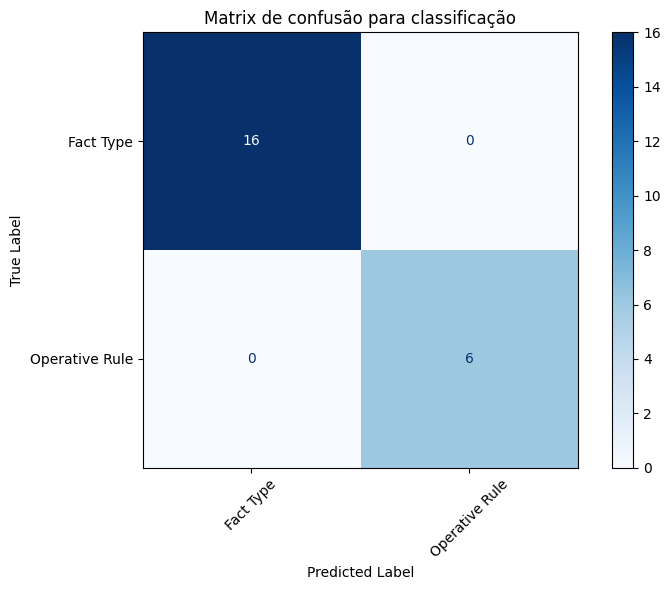

Classification Report:

                precision    recall  f1-score   support

     Fact Type     1.0000    1.0000    1.0000        16
Operative Rule     1.0000    1.0000    1.0000         6

      accuracy                         1.0000        22
     macro avg     1.0000    1.0000    1.0000        22
  weighted avg     1.0000    1.0000    1.0000        22



In [46]:
create_df_elements_results_confusion_matrix_classification(df_elements_results)

Analyzing the Distribution of Similarity Classifications

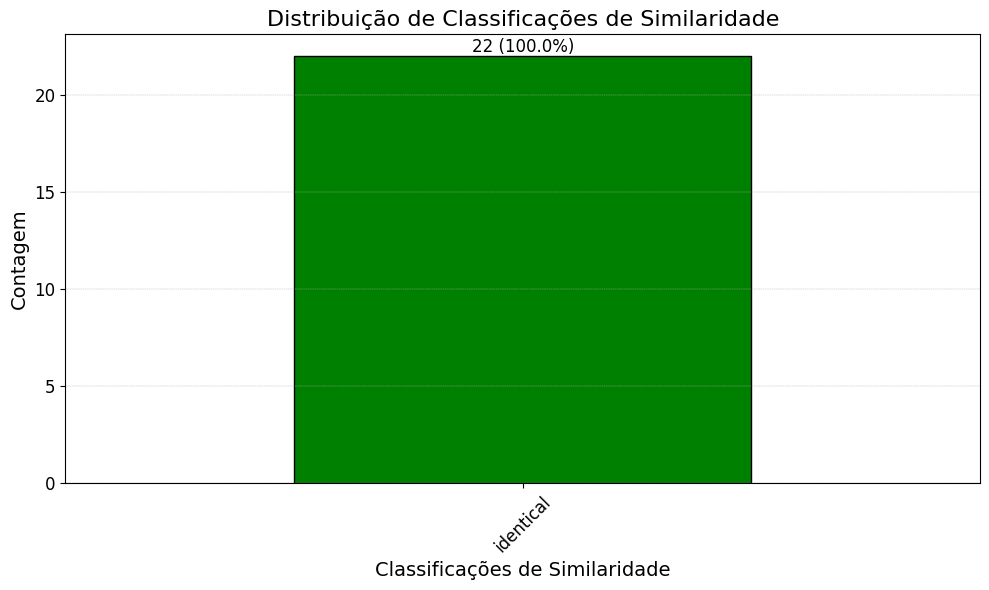

In [47]:
create_elements_results_distribution_similarity(df_elements_results)

##### Source identification

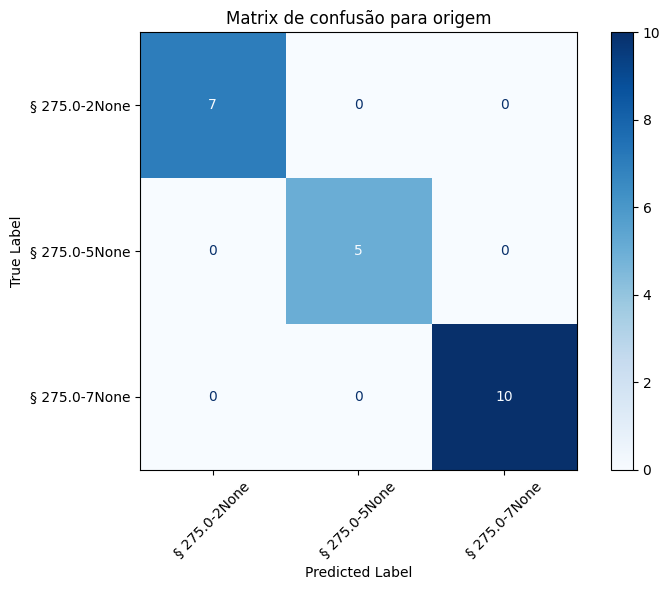

Classification Report:

               precision    recall  f1-score   support

§ 275.0-2None     1.0000    1.0000    1.0000         7
§ 275.0-5None     1.0000    1.0000    1.0000         5
§ 275.0-7None     1.0000    1.0000    1.0000        10

     accuracy                         1.0000        22
    macro avg     1.0000    1.0000    1.0000        22
 weighted avg     1.0000    1.0000    1.0000        22



In [48]:
create_df_elements_results_confusion_matrix_source(df_elements_results)

Analyzing the Distribution of Similarity Classifications

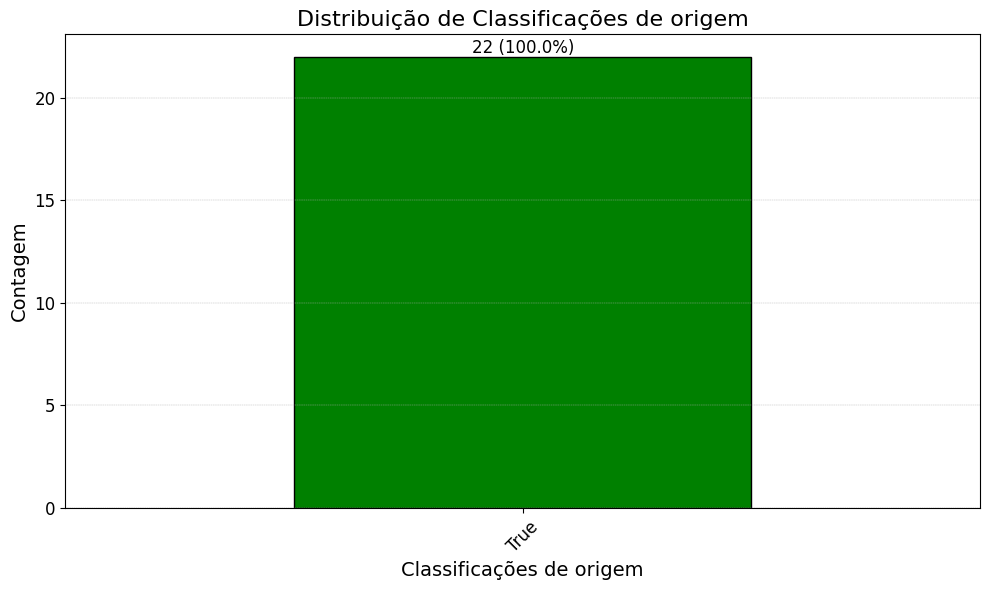

In [49]:
create_elements_results_distribution_source(df_elements_results)

##### Extract term's definition

In [50]:
len(pred_terms_extraction), len(true_terms_extraction)

(3, 3)

In [51]:
# Run the similarity check
similarity_terms_results = check_for_definitions_similarity(true_terms_extraction, pred_terms_extraction)

Total terms in true_terms: 70
Total matched terms in pred_terms: 70


Create a dataframe of true and pred elements

In [52]:
df_terms_results = create_df_terms_results(similarity_terms_results)

Show the first 10 terms in dataFrame. Yellow means above 80%, red means above 50%.

In [53]:
df_terms_results_styled = df_terms_results.head(10).style.apply(
    highlight_differences, axis=1
)

print("Styled DataFrame with Highlighted Similarity Scores:")
df_terms_results_styled

Styled DataFrame with Highlighted Similarity Scores:


Histogram of Similarity Scores

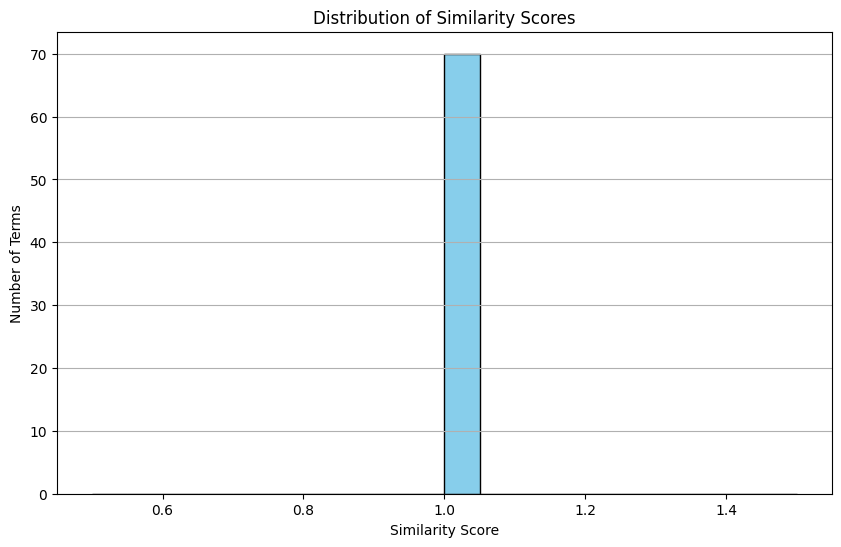

In [54]:
create_terms_results_distribution_similarity(df_terms_results)

Terms with Lowest Similarity Scores

In [55]:
# Identify Terms with Low Similarity Scores
df_sorted = df_terms_results.sort_values(by="similarity_score")

print("Top 10 Terms with Lowest Similarity Scores:")
display(df_sorted.head(10))

Top 10 Terms with Lowest Similarity Scores:


doc_id                     term  \
0   § 275.0-2              Association   
37  § 275.0-5  Protection of investors   
38  § 275.0-5                      Act   
39  § 275.0-5               Commission   
40  § 275.0-7                 Contract   
41  § 275.0-7              Fiscal year   
42  § 275.0-7                    Trust   
43  § 275.0-7              Partnership   
44  § 275.0-7                 Form ADV   
45  § 275.0-7       Small organization   

                                      definition_pred  \
0                                                       
37  A consideration for ordering a hearing if it a...   
38  The legislation under which the Commission ope...   
39  The regulatory body responsible for issuing or...   
40                                                      
41                                                      
42  A person is presumed to control a trust if the...   
43  A person is presumed to control a partnership ...   
44                                                      
45  An investment adviser with assets under manage...   

                                      definition_true  similarity_score  
0                                                                   1.0  
37  A consideration for ordering a hearing if it a...               1.0  
38  The legislation under which the Commission ope...               1.0  
39  The regulatory body responsible for issuing or...               1.0  
40                                                                  1.0  
41                                                                  1.0  
42  A person is presumed to control a trust if the...               1.0  
43  A person is presumed to control a partnership ...               1.0  
44                                                                  1.0  
45  An investment adviser with assets under manage...               1.0

Visualize Low Similarity Terms with a Bar Chart

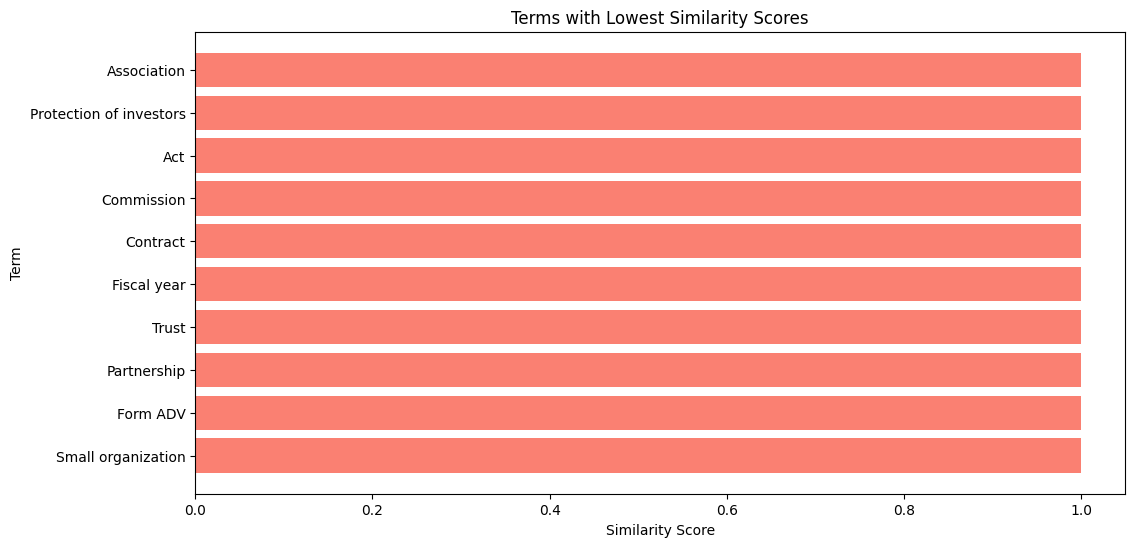

In [56]:
create_terms_results_histogram_low_similarity(df_terms_results, number_of_terms=10)

Analyze Similarity Scores by Document

Average Similarity Score per Document:


doc_id  similarity_score
0  § 275.0-2               1.0
1  § 275.0-5               1.0
2  § 275.0-7               1.0

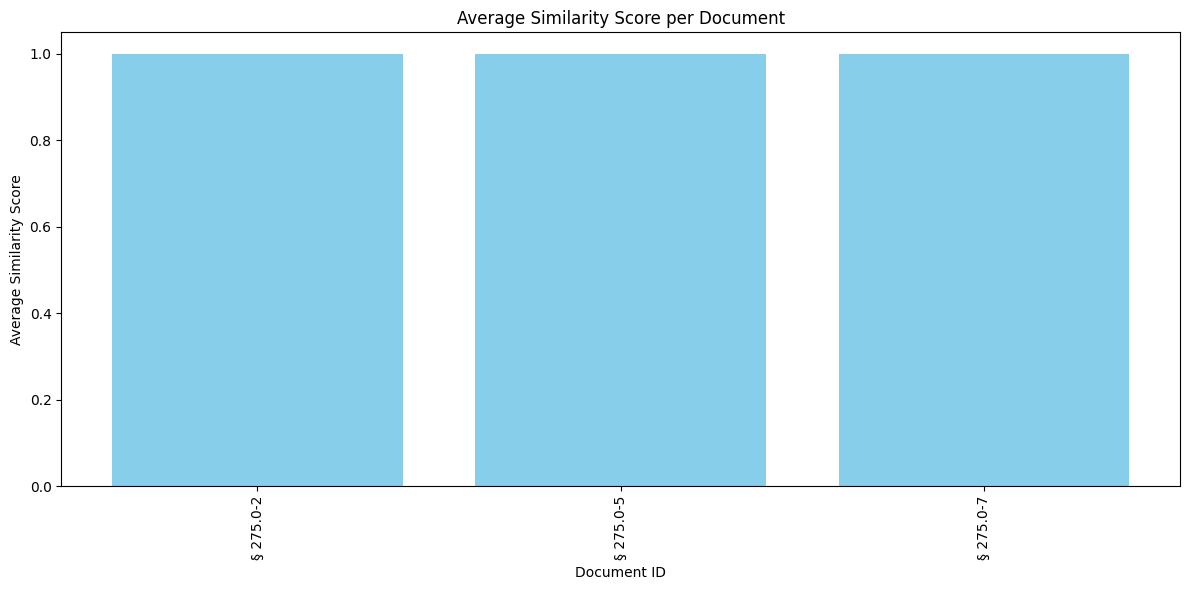

In [57]:
create_terms_results_average_similarity_per_document(df_terms_results)

Heatmap of Similarity Scores

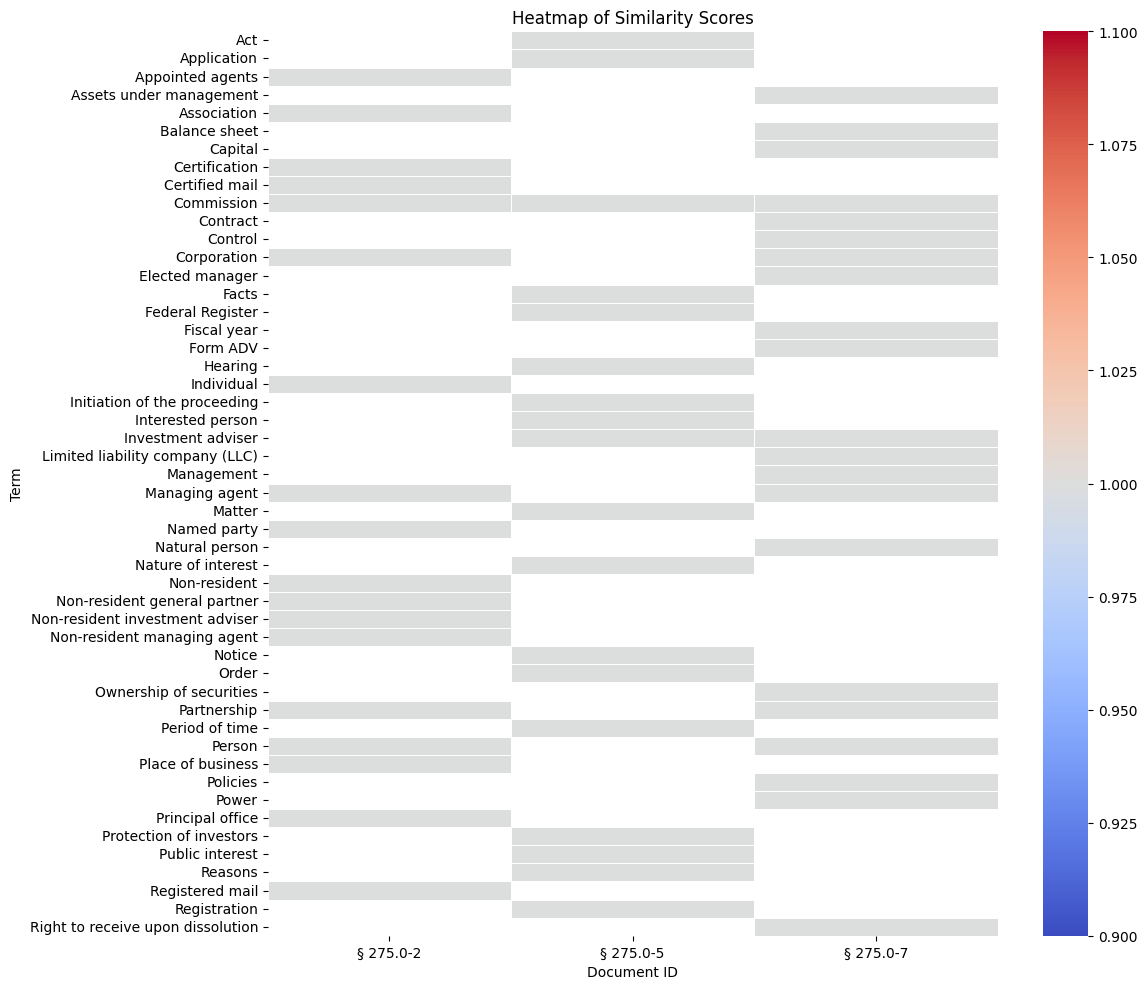

In [58]:
create_terms_results_heatmap(df_terms_results)

Interactive Visualization

In [59]:
fig = px.scatter(
    df_terms_results,
    x="term",
    y="similarity_score",
    hover_data=["definition_true", "definition_pred"],
    title="Similarity Scores per Term",
)
fig.update_layout(xaxis_title="Term", yaxis_title="Similarity Score")
fig.show()

Save Similarity Results to Excel

In [60]:
excel_filename = f'{config["DEFAULT_OUTPUT_DIR"]}/extract_p2_true_pred_results.xlsx'
df_terms_results.to_excel(excel_filename, index=False)

logger.info(f"Similarity results saved to '{excel_filename}'")

2024-11-30 18:45:35 - INFO - Similarity results saved to '../outputs/extract_p2_true_pred_results.xlsx'


##### Deep analysis of mismatches

Filter the DataFrame to only include rows where similarity_classification is 'not-sure'

In [61]:
df_not_sure = df_elements_results[
    df_elements_results["similarity_classification"] == "not-sure"
]

df_not_sure

Empty DataFrame
Columns: [doc_id, id_pred, id_true, classification_pred, classification_true, source_pred, source_true, filename_pred, statement_pred, statement_true, similarity_score, similarity_classification, classification_match, classification_match_label, source_match, source_match_label, id_match, id_match_label]
Index: []

Filter for 'close-match' entries

In [62]:
df_close_match = df_elements_results[
    df_elements_results["similarity_classification"] == "close-match"
]

df_close_match

Empty DataFrame
Columns: [doc_id, id_pred, id_true, classification_pred, classification_true, source_pred, source_true, filename_pred, statement_pred, statement_true, similarity_score, similarity_classification, classification_match, classification_match_label, source_match, source_match_label, id_match, id_match_label]
Index: []

Filter entries where the predicted classification does not match the true classification

In [63]:
df_classification_mismatch = df_elements_results[
    df_elements_results["classification_pred"]
    != df_elements_results["classification_true"]
]

df_classification_mismatch

Empty DataFrame
Columns: [doc_id, id_pred, id_true, classification_pred, classification_true, source_pred, source_true, filename_pred, statement_pred, statement_true, similarity_score, similarity_classification, classification_match, classification_match_label, source_match, source_match_label, id_match, id_match_label]
Index: []

In [64]:
df_classification_mismatch = df_elements_results[
    df_elements_results["classification_pred"]
    != df_elements_results["classification_true"]
]

# Display the filtered DataFrame
print(f"Classification mismatches: {len(df_classification_mismatch)}")

# Select specific columns to display
columns_to_display = [
    "doc_id",
    "id_pred",
    "id_true",
    "classification_pred",
    "classification_true",
    "similarity_score",
]
df_mismatch_selected = df_classification_mismatch[columns_to_display]

# Iterate over the mismatches and print details
for index, row in df_classification_mismatch.iterrows():
    print(f"Index: {index}")
    print(f"Doc ID: {row['doc_id']}")
    print(
        f"Predicted Classification (ID {row['id_pred']}): {row['classification_pred']}"
    )
    print(f"True Classification (ID {row['id_true']}): {row['classification_true']}")
    print(f"Similarity Score: {row['similarity_score']:.4f}")
    print(f"Predicted statement: {row['statement_pred']}")
    print(f"True statement: {row['statement_true']}")
    print("-" * 80)

# Get the number of classification mismatches
num_mismatches = len(df_classification_mismatch)
print(f"Number of classification mismatches: {num_mismatches}")

# Calculate mismatch percentage
total_comparisons = len(
    df_elements_results.dropna(subset=["classification_true", "classification_pred"])
)
mismatch_percentage = (num_mismatches / total_comparisons) * 100

print(f"Mismatch Percentage: {mismatch_percentage:.2f}%")

Classification mismatches: 0
Number of classification mismatches: 0
Mismatch Percentage: 0.00%


Filter entries where the predicted classification does not match the true classification

In [65]:
df_classification_mismatch = df_elements_results[
    df_elements_results["classification_pred"]
    != df_elements_results["classification_true"]
]

# Display the number of mismatches
num_mismatches = len(df_classification_mismatch)
print(f"Number of classification mismatches: {num_mismatches}")

# Display the mismatches
print(f"Number of classification mismatches: {num_mismatches}")

Number of classification mismatches: 0
Number of classification mismatches: 0


##### Conclusion

TODO

#### Classify elements

Validating results from chap_6_semantic_annotation_elements_classification.ipynb

- Classify operative rules by top-level taxonomy: Activity, Data, Party
- Classify elements by taxonomy and get templates
    - operative rules
    - facts
    - terms
    - names

##### Operative rules

Validate taxonomy top-level classification.

Compare predict and true values

In [66]:
comparison_operative_rules = compare_documents(
    pred_operative_rules_classify,
    true_operative_rules_p1_classify,
    ["type", "statement_id"],
)
comparison_operative_rules_cm = create_confusion_matrices(comparison_operative_rules)
comparison_operative_rules_metrics = calculate_metrics(comparison_operative_rules)

2024-11-30 18:45:35 - INFO - Confusion matrix for type:
                Activity rules  Party rules
Activity rules               3            0
Party rules                  0            3
2024-11-30 18:45:35 - INFO - Confusion matrix for statement_id:
   1  2  3  4
1  1  0  0  0
2  0  1  0  0
3  0  0  2  0
4  0  0  0  2
2024-11-30 18:45:35 - INFO - Metrics for type: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
2024-11-30 18:45:35 - INFO - Metrics for statement_id: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


key=('§ 275.0-2', '3', ('(a)(2)',)), true_doc={'doc_id': '§ 275.0-2', 'statement_id': '3', 'statement': "The Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission.", 'sources': ['(a)(2)'], 'type': 'Party rules'}, pred_doc={'doc_id': '§ 275.0-2', 'statement_id': 3, 'statement_title': 'Forwarding documents by the Secretary', 'statement': "The Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission.", 'sources': ['(a)(2)'], 'terms': [{'term': 'Secretary of the Commission', 'classification': 'Proper Noun', 'confidence': 0.9, 'reason': 'The term refers to a specific role within the Commission.', 'extracted_confidence': 0.9, 'extracted_reason': 'The term is explicitly mentioned as the subject performing the action.'}, {'term': 'Named party', 'classificat

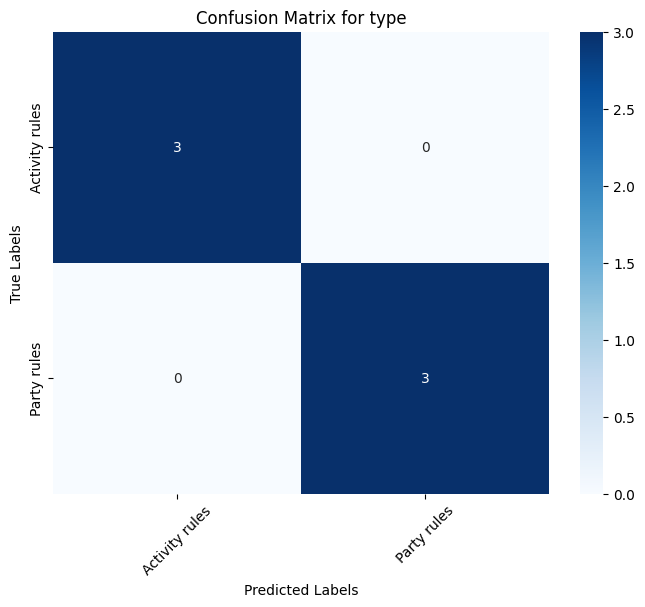

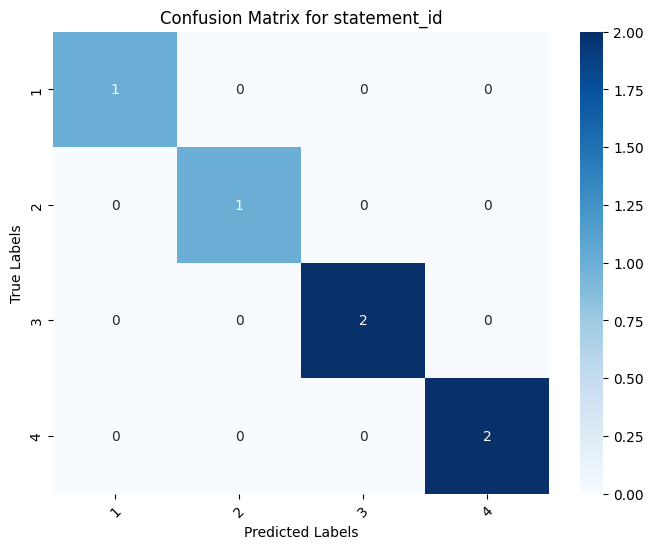

In [67]:
plot_confusion_matrices(comparison_operative_rules_cm)

Save comparison results

In [68]:
save_comparison_to_excel(
    comparison_operative_rules,
    comparison_operative_rules_cm,
    comparison_operative_rules_metrics,
    filename=f"{config['DEFAULT_OUTPUT_DIR']}/comparison_operative_rules_results.xlsx",
)

2024-11-30 18:45:36 - INFO - Comparison results saved to ../outputs/comparison_operative_rules_results.xlsx


##### Facts and Fact types

In [69]:
# Example usage with pred_operative_rules and true_operative_rules
comparison_facts = compare_documents(
    pred_facts_classify, true_facts_classify, ["subtype", "statement_id"]
)
comparison_facts_cm = create_confusion_matrices(comparison_facts)
comparison_facts_metrics = calculate_metrics(comparison_facts)

2024-11-30 18:45:36 - INFO - Confusion matrix for subtype:
                                Formal extensional definitions  \
Formal extensional definitions                               4   
Formal intensional definitions                               0   
Valid value definitions                                      0   

                                Formal intensional definitions  \
Formal extensional definitions                               0   
Formal intensional definitions                              10   
Valid value definitions                                      0   

                                Valid value definitions  
Formal extensional definitions                        0  
Formal intensional definitions                        0  
Valid value definitions                               2  
2024-11-30 18:45:36 - INFO - Confusion matrix for statement_id:
    1  10  2  3  4  5  6  7  8  9
1   2   0  0  0  0  0  0  0  0  0
10  0   1  0  0  0  0  0  0  0  0
2   0   0  2 

key=('§ 275.0-2', '1', ('(a)',)), true_doc={'doc_id': '§ 275.0-2', 'statement_id': '1', 'statement': 'A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.', 'sources': ['(a)'], 'subtype': 'Formal extensional definitions', 'templates_ids': ['T8']}, pred_doc={'doc_id': '§ 275.0-2', 'statement_id': 1, 'statement_title': 'Service of process on non-resident entities', 'statement': 'A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.', 'sources': ['(a)'], 'terms': [{'term': 'Person', 'classification': 'Common Noun', 'confidence': 0.9, 'reason': 'The term is a general reference to an individual or entity.', 'extracted_confidence': 0.9, 'e

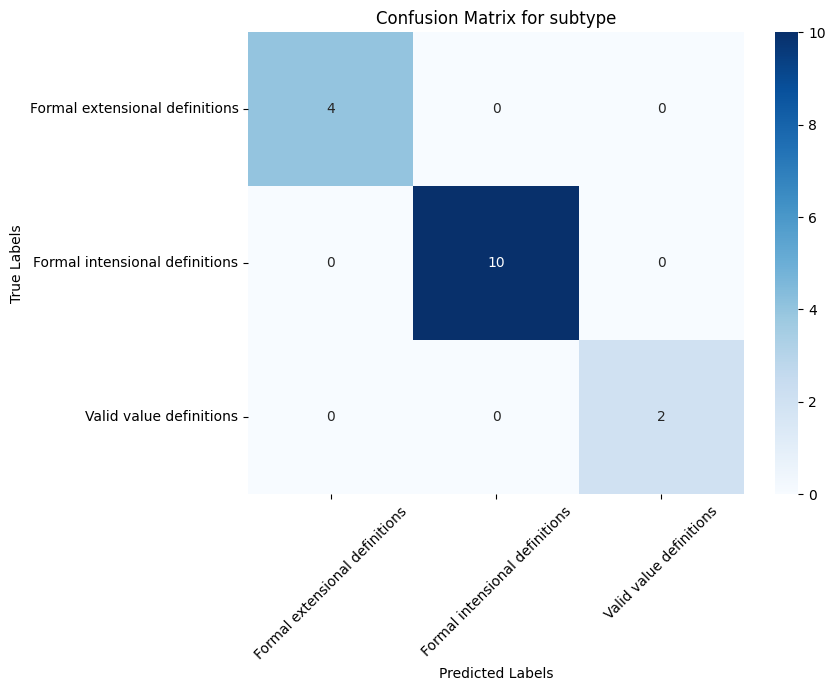

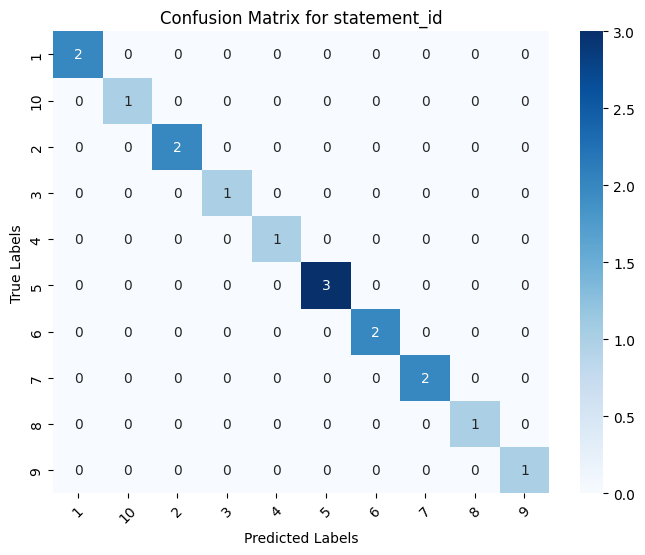

In [70]:
plot_confusion_matrices(comparison_facts_cm)

Save comparison results

In [71]:
save_comparison_to_excel(
    comparison_facts,
    comparison_facts_cm,
    comparison_facts_metrics,
    filename=f"{config['DEFAULT_OUTPUT_DIR']}/comparison_facts_results.xlsx",
)

2024-11-30 18:45:36 - INFO - Comparison results saved to ../outputs/comparison_facts_results.xlsx


##### Terms

In [72]:
# Example usage with pred_operative_rules and true_operative_rules
comparison_terms = compare_documents(
    pred_terms_classify, true_terms_classify, ["subtype", "statement_id"]
)
comparison_terms_cm = create_confusion_matrices(comparison_terms)
comparison_terms_metrics = calculate_metrics(comparison_terms)

2024-11-30 18:45:36 - INFO - Confusion matrix for subtype:
                                Formal extensional definitions  \
Formal extensional definitions                               3   
Formal intensional definitions                               0   
Symbolic literal definitions                                 0   

                                Formal intensional definitions  \
Formal extensional definitions                               0   
Formal intensional definitions                              19   
Symbolic literal definitions                                 0   

                                Symbolic literal definitions  
Formal extensional definitions                             0  
Formal intensional definitions                             0  
Symbolic literal definitions                               1  
2024-11-30 18:45:36 - INFO - Confusion matrix for statement_id:
                                 Application  Control  Facts  Hearing  \
Application           

key=('§ 275.0-2', 'Managing agent', ('(b)(1)',)), true_doc={'doc_id': '§ 275.0-2', 'statement_id': 'Managing agent', 'statement': 'Any person, including a trustee, who directs or manages, or who participates in directing or managing, the affairs of any unincorporated organization or association other than a partnership.', 'sources': ['(b)(1)'], 'subtype': 'Formal intensional definitions', 'templates_ids': ['T7']}, pred_doc={'doc_id': '§ 275.0-2', 'statement_id': 'Managing agent', 'definition': 'Any person, including a trustee, who directs or manages, or who participates in directing or managing, the affairs of any unincorporated organization or association other than a partnership.', 'isLocalScope': True, 'sources': ['(b)(1)'], 'element_name': 'Term', 'transformed': 'A managing agent is by definition a person who directs or manages, or who participates in directing or managing, the affairs of any unincorporated organization or association other than a partnership.', 'semscore': 0.65502

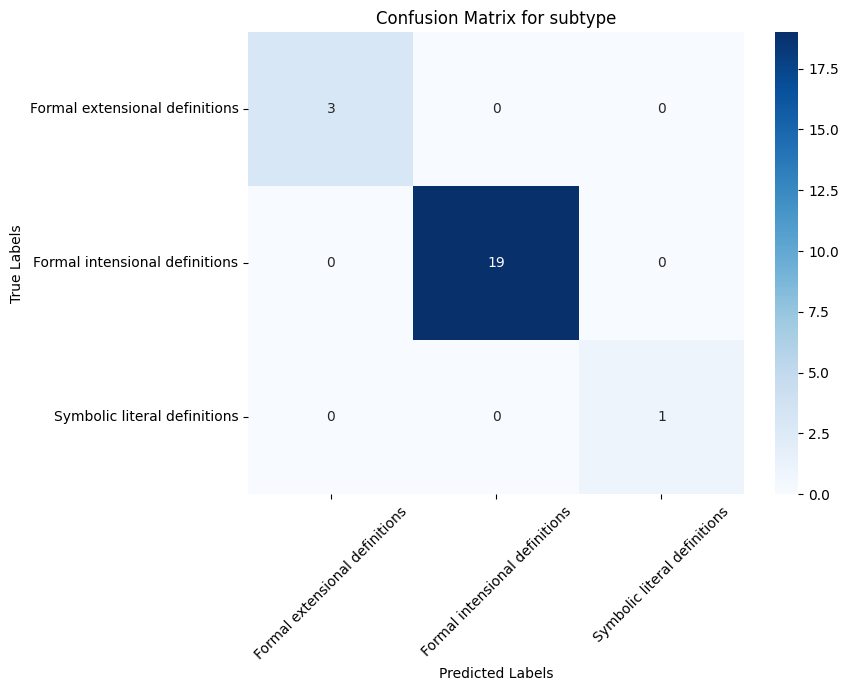

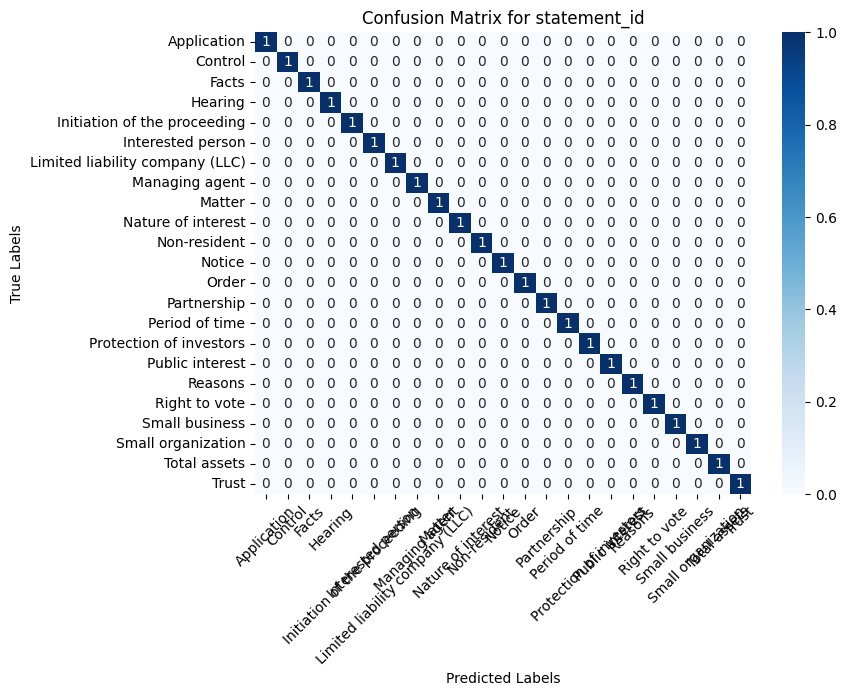

In [73]:
plot_confusion_matrices(comparison_terms_cm)

Save comparison results

In [74]:
save_comparison_to_excel(
    comparison_terms,
    comparison_terms_cm,
    comparison_terms_metrics,
    filename=f"{config['DEFAULT_OUTPUT_DIR']}/comparison_terms_results.xlsx",
)

2024-11-30 18:45:37 - INFO - Comparison results saved to ../outputs/comparison_terms_results.xlsx


Investigating mismatches

How many terms in both sides?

In [75]:
len(pred_terms_classify), len(true_terms_classify)

(23, 23)

Identifies mismatches between true and predicted values for different sections of data stored in the comparison_terms dictionary.

In [76]:
data = comparison_terms

# Initialize a dictionary to store mismatch information
mismatches = {"subtype": [], "statement_id": []}


# Function to find mismatches
def find_mismatches(y_true, y_pred):
    return [
        (index, true, pred)
        for index, (true, pred) in enumerate(zip(y_true, y_pred))
        if true != pred
    ]


# Process each section
for key in data:
    mismatches[key] = find_mismatches(data[key]["y_true"], data[key]["y_pred"])

# Output mismatches
for key, mismatches_list in mismatches.items():
    print(f"\nMismatches in {key}:")
    for idx, true_value, pred_value in mismatches_list:
        print(f"Index {idx} - y_true: '{true_value}' vs y_pred: '{pred_value}'")


Mismatches in subtype:

Mismatches in statement_id:


Looking for duplicate terms

In [77]:
# Track seen items and duplicates
seen_terms = set()
duplicates = []

# Check for duplicates by specified fields
for term in true_terms_classify:
    # Create a unique key from the specified fields
    key = (term["doc_id"], term["statement_id"], term["statement"], tuple(sorted(term["sources"])))
    if key in seen_terms:
        duplicates.append(term)
    else:
        seen_terms.add(key)

# Output results
if duplicates:
    print("Duplicate entries found in true_terms based on specified fields:")
    for dup in duplicates:
        print(dup)
else:
    print("No duplicate entries found in true_terms based on specified fields.")

No duplicate entries found in true_terms based on specified fields.


##### Names

In [78]:
# Example usage with pred_operative_rules and true_operative_rules
comparison_names = compare_documents(
    pred_names_classify, true_names_classify, ["subtype", "statement_id"]
)
comparison_names_cm = create_confusion_matrices(comparison_names)
comparison_names_metrics = calculate_metrics(comparison_names)

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning:

A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.

2024-11-30 18:45:38 - INFO - Confusion matrix for subtype:
                                Formal intensional definitions
Formal intensional definitions                               5
2024-11-30 18:45:38 - INFO - Confusion matrix for statement_id:
                             Act  Commission  Federal Register  Secretary  \
Act                            1           0                 0          0   
Commission                     0           1                 0          0   
Federal Register               0           0                 1          0   
Secretary                      0           0                 0          1   
Secretary of the Commission    0           0                 0          0   

    

key=('§ 275.0-2', 'Secretary of the Commission', ('(a)(2)',)), true_doc={'doc_id': '§ 275.0-2', 'statement_id': 'Secretary of the Commission', 'statement': 'The Secretary of the Commission is responsible for forwarding copies of process, pleadings, or other papers to each named party by registered or certified mail.', 'sources': ['(a)(2)'], 'subtype': 'Formal intensional definitions', 'templates_ids': ['T7']}, pred_doc={'doc_id': '§ 275.0-2', 'statement_id': 'Secretary of the Commission', 'definition': 'The Secretary of the Commission is responsible for forwarding copies of process, pleadings, or other papers to each named party by registered or certified mail.', 'isLocalScope': True, 'sources': ['(a)(2)'], 'element_name': 'Name', 'transformed': 'A Secretary of the Commission is by definition a person who is responsible for forwarding copies of process, pleadings, or other papers to each named party by registered or certified mail.', 'semscore': 0.8502523788760009, 'similarity_score': 

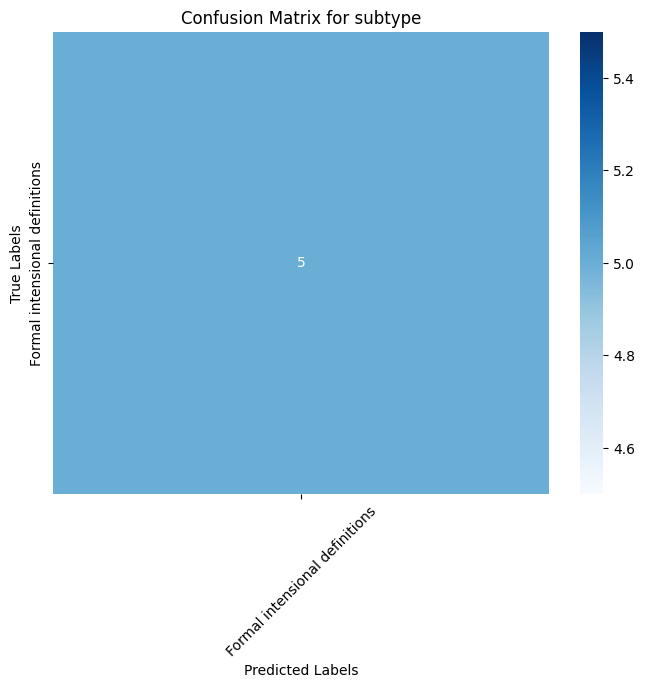

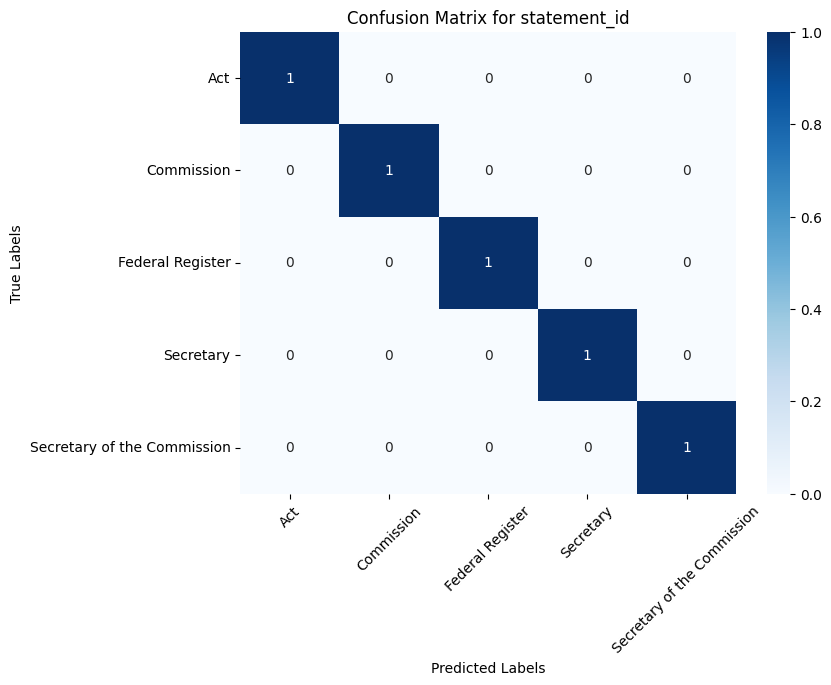

In [79]:
plot_confusion_matrices(comparison_names_cm)

Save comparison results

In [80]:
save_comparison_to_excel(
    comparison_names,
    comparison_names_cm,
    comparison_names_metrics,
    filename=f"{config['DEFAULT_OUTPUT_DIR']}/comparison_names_results.xlsx",
)

2024-11-30 18:45:38 - INFO - Comparison results saved to ../outputs/comparison_names_results.xlsx


##### Operational rules (P2)

In [81]:
# Example usage with pred_operative_rules and true_operative_rules
comparison_operative_rules_p2 = compare_documents(
    pred_operative_rules_classify, true_operative_rules_p2_classify, ["subtype", "statement_id"]
)
comparison_rules_p2_cm = create_confusion_matrices(comparison_operative_rules_p2)
comparison_rules_p2_metrics = calculate_metrics(comparison_operative_rules_p2)

2024-11-30 18:45:38 - INFO - Confusion matrix for subtype:
                           Activity obligation rules  \
Activity obligation rules                          1   
Activity time limit rules                          0   
Party restriction rules                            0   
Process decision rules                             0   
Responsibility rules                               0   

                           Activity time limit rules  Party restriction rules  \
Activity obligation rules                          0                        0   
Activity time limit rules                          1                        0   
Party restriction rules                            0                        1   
Process decision rules                             0                        0   
Responsibility rules                               0                        0   

                           Process decision rules  Responsibility rules  
Activity obligation rules                  

key=('§ 275.0-2', '3', ('(a)(2)',)), true_doc={'doc_id': '§ 275.0-2', 'statement_id': '3', 'statement': "The Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission.", 'sources': ['(a)(2)'], 'subtype': 'Responsibility rules', 'templates_ids': ['T56']}, pred_doc={'doc_id': '§ 275.0-2', 'statement_id': 3, 'statement_title': 'Forwarding documents by the Secretary', 'statement': "The Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission.", 'sources': ['(a)(2)'], 'terms': [{'term': 'Secretary of the Commission', 'classification': 'Proper Noun', 'confidence': 0.9, 'reason': 'The term refers to a specific role within the Commission.', 'extracted_confidence': 0.9, 'extracted_reason': 'The term is explicitly mentioned as the subject performing the action.'}

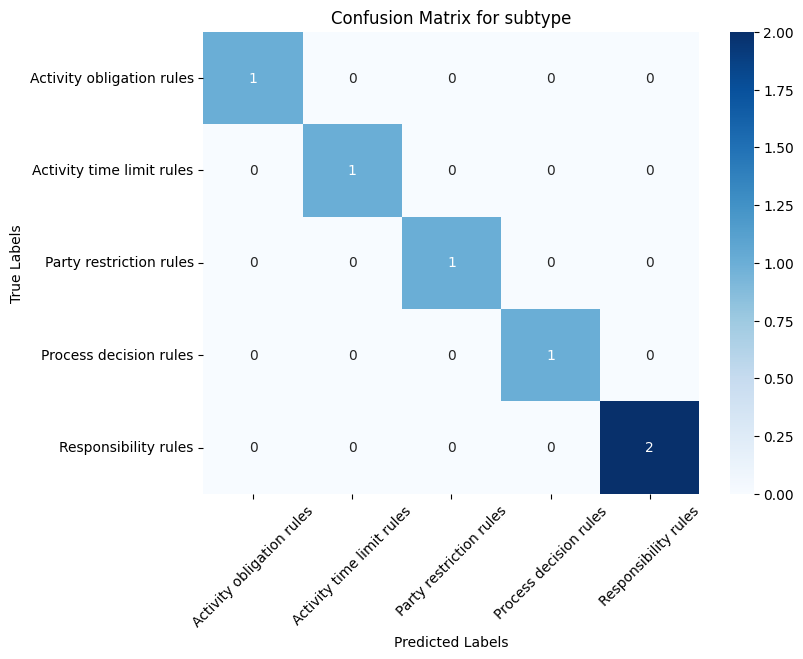

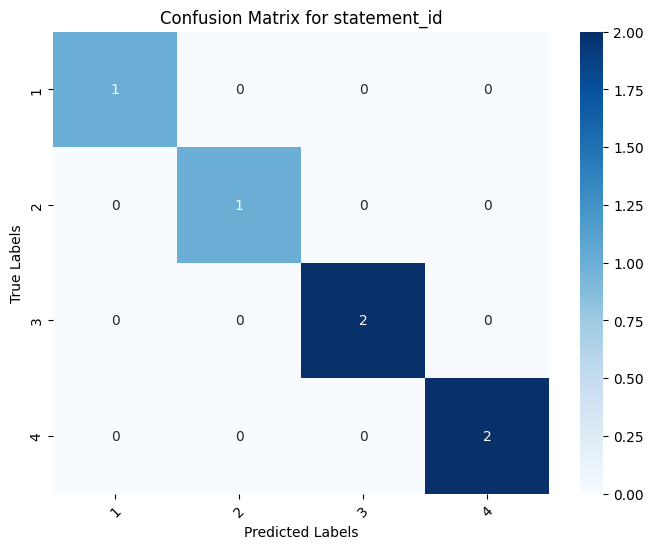

In [82]:
plot_confusion_matrices(comparison_rules_p2_cm)

Save comparison results

In [83]:
save_comparison_to_excel(
    comparison_operative_rules_p2,
    comparison_rules_p2_cm,
    comparison_rules_p2_metrics,
    filename=f"{config['DEFAULT_OUTPUT_DIR']}/comparison_operative_rules_p2_results.xlsx",
)

2024-11-30 18:45:39 - INFO - Comparison results saved to ../outputs/comparison_operative_rules_p2_results.xlsx


### nlp2sbvr

#### Load checkpoints for evaluation

Restore all checkpoints

In [84]:
# managers, file_info_list = get_all_checkpoints(config["DEFAULT_CHECKPOINT_DIR"])

# pred_operative_rules = []
# pred_facts = []
# pred_terms = []
# pred_names = []
# pred_files = []

# for manager, file_info in zip(managers, file_info_list):
#     # Process documents
#     processor = DocumentProcessor(manager)

#     # Access processed data
#     pred_operative_rules += processor.get_rules()
#     pred_facts += processor.get_facts()
#     pred_terms += processor.get_terms(definition_filter="non_null")
#     pred_names += processor.get_names(definition_filter="non_null")
#     pred_files.append(file_info)

# logger.debug(f"Rules: {pred_operative_rules}")
# logger.debug(f"Facts: {pred_facts}")
# logger.debug(f"Terms: {pred_terms}")
# logger.debug(f"Names: {pred_names}")
# logger.info(f"Rules to evaluate: {len(pred_operative_rules)}")
# logger.info(f"Facts to evaluate: {len(pred_facts)}")
# logger.info(f"Terms to evaluate: {len(pred_terms)}")
# logger.info(f"Names to evaluate: {len(pred_names)}")

In [85]:
# pred_operative_rules_classify, pred_facts_classify, pred_terms_classify, pred_names_classify, pred_files_classify = (
#     get_elements_from_checkpoints(config["DEFAULT_CHECKPOINT_DIR"])
# )

#### Elements measurements

From chapter 7.2.3 Terms, facts, and rules

##### Measuring similarity with SEMSCORE

Evaluating SEMSCORE (AYNETDINOV;AKBIK, 2024) between the predicted and true statements for each element.

> WARNING: Expensive operation!


Set dataset to evaluation and check empty transformed elements

In [86]:
# data = [pred_facts_classify, pred_terms_classify, pred_names_classify, pred_operative_rules_classify]
# data_names = ["pred_facts", "pred_terms", "pred_names", "pred_operative_rules"]
data = (pred_facts_classify, pred_terms_classify, pred_names_classify, pred_operative_rules_classify)
data_names = ("pred_facts", "pred_terms", "pred_names", "pred_operative_rules")

for element_list, element_name in zip(data, data_names):
    empty_transformed_elements = [
        element for element in element_list if not element["transformed"]
    ]
    logger.info(
        f"Empty transformed {element_name}: {len(empty_transformed_elements)}/{len(element_list)}"
    )

2024-11-30 18:45:39 - INFO - Empty transformed pred_facts: 0/16
2024-11-30 18:45:39 - INFO - Empty transformed pred_terms: 0/23
2024-11-30 18:45:39 - INFO - Empty transformed pred_names: 0/5
2024-11-30 18:45:39 - INFO - Empty transformed pred_operative_rules: 0/6


Saving variables for reuse, operation is expensive

In [87]:
SKIP = False

In [88]:
if not SKIP:
    for element_list, data_name in zip(data, data_names):
        for element in element_list:
            # Check if 'semscore' is already calculated
            if "semscore" not in element or element["semscore"] is None:
                original_sentence = element.get("statement", element.get("definition"))
                transformed_sentence = element.get("transformed")
                templates_ids = element.get("templates_ids")
                element_name = element.get("element_name")

                # Remove keys if they exist
                for key in [
                    "explanation",
                    "confidence",
                    "subtype_confidence",
                    "subtype_explanation",
                ]:
                    element.pop(key, None)  # Using pop with None to avoid KeyError

                logger.debug(f"{element_name=}")
                logger.debug(
                    f"{data_name} - {element['statement_id']}: {element['doc_id']}{element['sources']}\nOriginal Sentence: {original_sentence}\nTransformed Sentence: {transformed_sentence}\ntemplates: {templates_ids}\n"
                )
                logger.debug(f"{element=}")

                # Calculate similarity score
                similarity = compare_sentences(original_sentence, transformed_sentence)
                logger.info(f"element: {element_name}, similarity score: {similarity}\n")

                # Assign the calculated score to 'semscore'
                element["semscore"] = similarity
                logger.debug(f"element: {element}\n")
            else:
                logger.debug(
                    f"{element.get('element_name')} already has a semscore: {element['semscore']}"
                )

    # Save the objects
    with open("objs.pkl", "wb") as f:
        pickle.dump([pred_facts_classify, pred_terms_classify, pred_names_classify, pred_operative_rules_classify], f)
else:
    # Restore the objects
    with open("objs.pkl", "rb") as f:
        pred_facts_classify, pred_terms_classify, pred_names_classify, pred_operative_rules_classify = pickle.load(f)

Check if SEMSCORE was calculated.

In [89]:
# Check for 'semscore' in each list of dictionaries
semscore_in_operative_rules = all(
    "semscore" in item and item["semscore"] is not None for item in pred_operative_rules_classify
)
semscore_in_facts = all(
    "semscore" in item and item["semscore"] is not None for item in pred_facts_classify
)
semscore_in_terms = all(
    "semscore" in item and item["semscore"] is not None for item in pred_terms_classify
)
semscore_in_names = all(
    "semscore" in item and item["semscore"] is not None for item in pred_names_classify
)

# Log information including whether 'semscore' exists and is not None
logger.info(
    f"Operative Rules to evaluate: {len(pred_operative_rules_classify)}, semscore was calculated: {semscore_in_operative_rules}"
)
logger.info(
    f"Facts to evaluate: {len(pred_facts_classify)}, semscore was calculated: {semscore_in_facts}"
)
logger.info(
    f"Terms to evaluate: {len(pred_terms_classify)}, semscore was calculated: {semscore_in_terms}"
)
logger.info(
    f"Names to evaluate: {len(pred_names_classify)}, semscore was calculated: {semscore_in_names}"
)

2024-11-30 18:45:39 - INFO - Operative Rules to evaluate: 6, semscore was calculated: True
2024-11-30 18:45:39 - INFO - Facts to evaluate: 16, semscore was calculated: True
2024-11-30 18:45:39 - INFO - Terms to evaluate: 23, semscore was calculated: True
2024-11-30 18:45:39 - INFO - Names to evaluate: 5, semscore was calculated: True


#### Evaluation criterias (SHANKAR et al., 2024)

Based on the prompt, there are three inferred evaluation criteria that align with the approach proposed by EvalGen (SHANKAR et al., 2024):

1. **Similarity Score**
   - Given the original_sentence and tranformed_sentence, how similar are they from 0 to 1? And how confident are you about your estimation from 0 to 1?

2. **Transformation Accuracy**
   - From 0 to 1, how does the "transformed_sentence" reflect the original_sentence with the structure and phrasing provided by the template?

3. **Grammar and Syntax Accuracy**
   - How is the transformed sentence grammatically correct and syntactically accurate from 0 to 1?

##### LLM-as-a-judge

References of the LLM-as-a-judge approach: (WEI; CHEN; LUO, 2024), (DONG; HU; COLLIER, 2024), (ZHENG et al., 2023)

Prompt engineering

System prompt

In [90]:
def get_system_prompt_judge_sentence_similarity(template):
    return f"""
   # Task

   You're an expert in judging sentence similarity and transformation using a template. 

   These criteria should support the evaluation process by verifying classification accuracy, template application, and transformation fidelity.

   Check the criteria and evaluate the output:

   1. **Similarity Score**
      - Given the statement or definition and tranformed sentence (transformed), how similar are they from 0 to 1? And how confident are you about your estimation from 0 to 1?

   2. **Transformation Accuracy**
      - From 0 to 1, how does the transformed sentence (transformed) reflect the original sentence (statement or definition) with the structure and phrasing provided by the template and subtemplates?

   3. **Grammar and Syntax Accuracy**
      - How is the transformed sentence (transformed) grammatically correct and syntactically accurate from 0 to 1?

   # Output Format

   Record your evaluation in JSON format as follows:

   ```json
   {{
      "doc_id": "<Document ID>",
      "statement_id": "<Statement ID>",
      "sources": ["<source>"],
      "similarity_score": <Similarity score>,
      "similarity_score_confidence": <Confidence score>,
      "transformation_accuracy": <Transformation score>,
      "grammar_syntax_accuracy": <Grammar score>,
      "findings": ["<Things found during the evaluation and worth to be mentioned>", 
                  "<other things to mention>"
                  ],
      "semscore": <original semscore>
   }}
   ```

   # Input example

   {{
      "doc_id": <Document ID>,
      "statement_id": <Statement ID>,
      "statement or definition": <original sentence>,
      "sources": [<source>],
      "terms": [
         {{"term": <signifier>, "classification": <Proper or Common Noun>}},
         ...
      ],
      "verb_symbols": <verbs or phrasal verbs>,
      "element_name": <name of element: Name, Term, Fact, Fact Type, Operative Rule>,
      "transformed": <transformed sentence>,
      "type": <type of element: Definitional, Activity, Party, Data>,
      "subtype": <subtype of element>,
      "templates_ids": ["T8"],
      "semscore": <semscore>
   }}

   # Templates and Subtemplates

   {template}
   """

User prompt

In [91]:
def get_user_prompt_judge_sentence_similarity(element_name, rule):
    return f"""
# rule data for an element: {element_name}

{json.dumps(rule, indent=2)}
    """

##### Measuring similarity with LLM Judge

Preparing system and user prompts for each element and call the judge.

In [92]:
for element_list, data_name in zip(data, data_names):

    system_prompts, user_prompts, element_name = get_prompts_for_judge(
        element_list, config["DEFAULT_DATA_DIR"]
    )

    responses = evaluate_statement(
        element_name=element_name,
        user_prompts=user_prompts,
        system_prompts=system_prompts,
        manager=manager,
    )

    logger.debug(f"{responses=}")

    # Persist the state to a file
    save_checkpoint(filename=config["DEFAULT_CHECKPOINT_FILE"], manager=manager)

2024-11-30 18:45:39 - INFO - System prompts for Fact Types: 16
2024-11-30 18:45:39 - INFO - User prompts for Fact Types: 16
2024-11-30 18:45:39 - INFO - Processing evaluation prompt 1 for Fact Type.
2024-11-30 18:45:42 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-30 18:45:42 - INFO - Tokes used: CompletionUsage(completion_tokens=190, prompt_tokens=2047, total_tokens=2237, completion_tokens_details=None, prompt_tokens_details=None)
2024-11-30 18:45:42 - INFO - Execution time for query_instruct_llm: 2.51 seconds
2024-11-30 18:45:42 - INFO - Finished processing evaluation 1.
2024-11-30 18:45:42 - INFO - Waiting 2s before processing the next prompt to avoid rate limits
2024-11-30 18:45:44 - INFO - Processing evaluation prompt 2 for Fact Type.
2024-11-30 18:45:49 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-30 18:45:49 - INFO - Tokes used: CompletionUsage(completion_tokens=230, prompt_tok

Average similarity score per document 5s.

## Elements evaluation

2024-11-30 18:49:25 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-11-29-4.json
2024-11-30 18:49:25 - INFO - Checkpoint restored from ../data/checkpoints/documents-2024-11-29-4.json.
2024-11-30 18:49:25 - INFO - Processing All Elements
----------------------------------------
2024-11-30 18:49:25 - INFO - 
Processing Element Type: Operative_Rules


Semscore Statistics:


semscore
count  6.000000
mean   0.938031
std    0.027420
min    0.899960
25%    0.922805
50%    0.936154
75%    0.955014
max    0.976261
range  0.076301
IQR    0.032209


Similarity Score Statistics:


similarity_score
count          6.000000
mean           0.908333
std            0.049160
min            0.850000
25%            0.862500
50%            0.925000
75%            0.950000
max            0.950000
range          0.100000
IQR            0.087500

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.




Pearson Correlation between semscore and similarity_score: 0.5576
Spearman Correlation between semscore and similarity_score: 0.4629

Intraclass Correlation Coefficient (ICC) between semscore and similarity_score: 0.3461


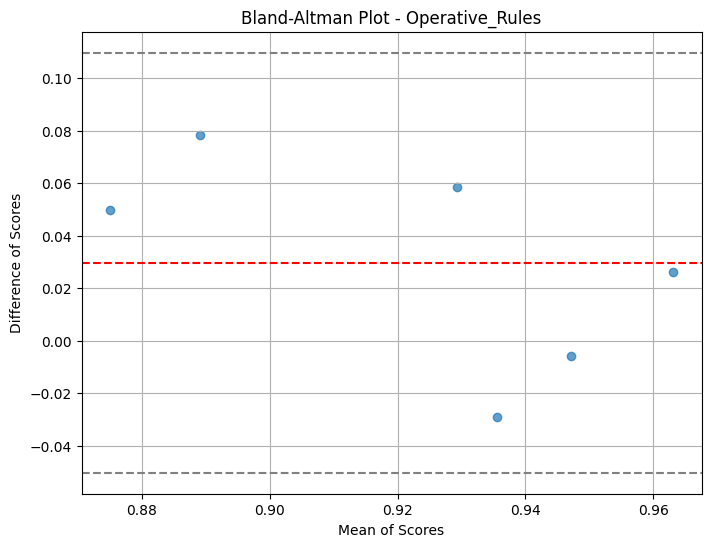

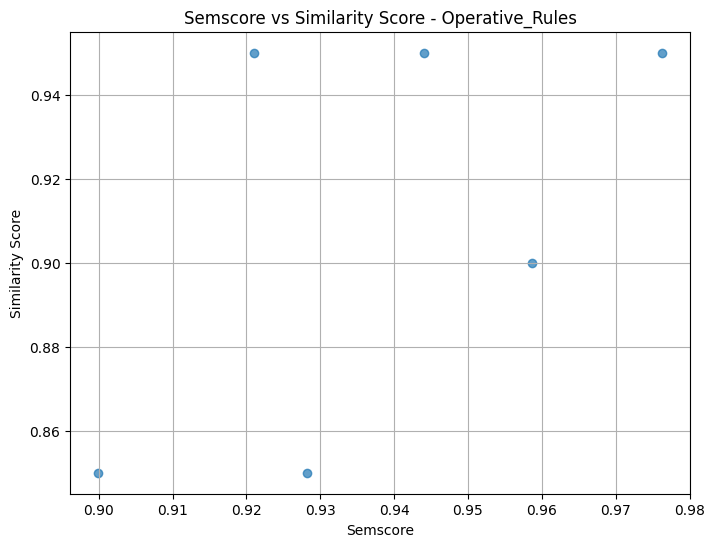

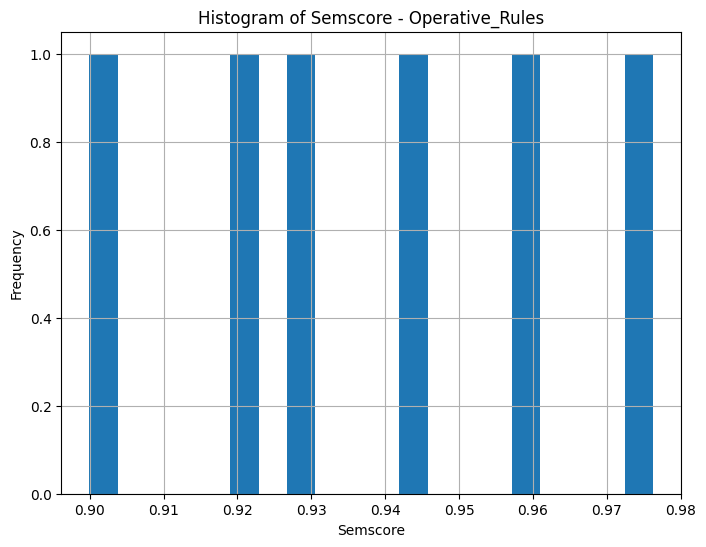

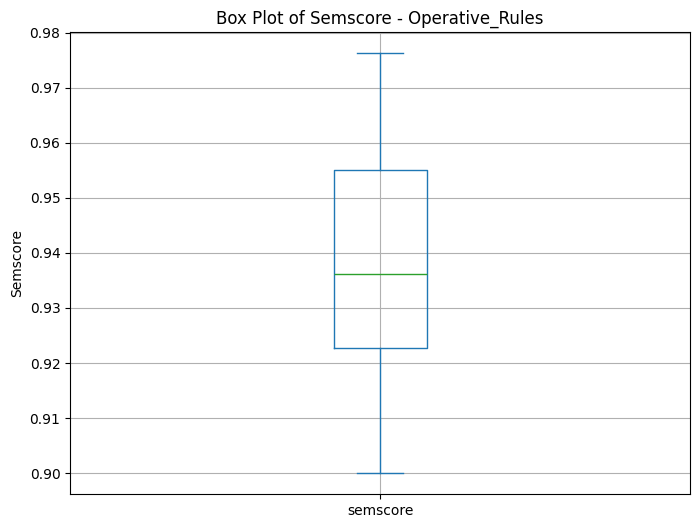

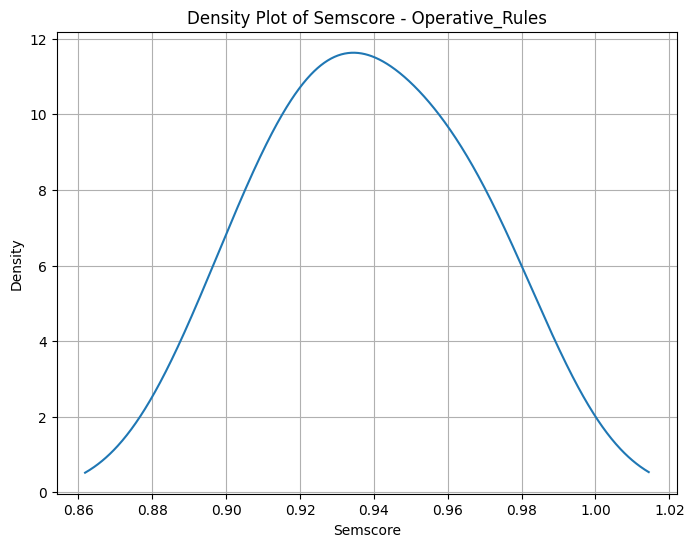


Count of Transformation Accuracy scores above 0.8: 3


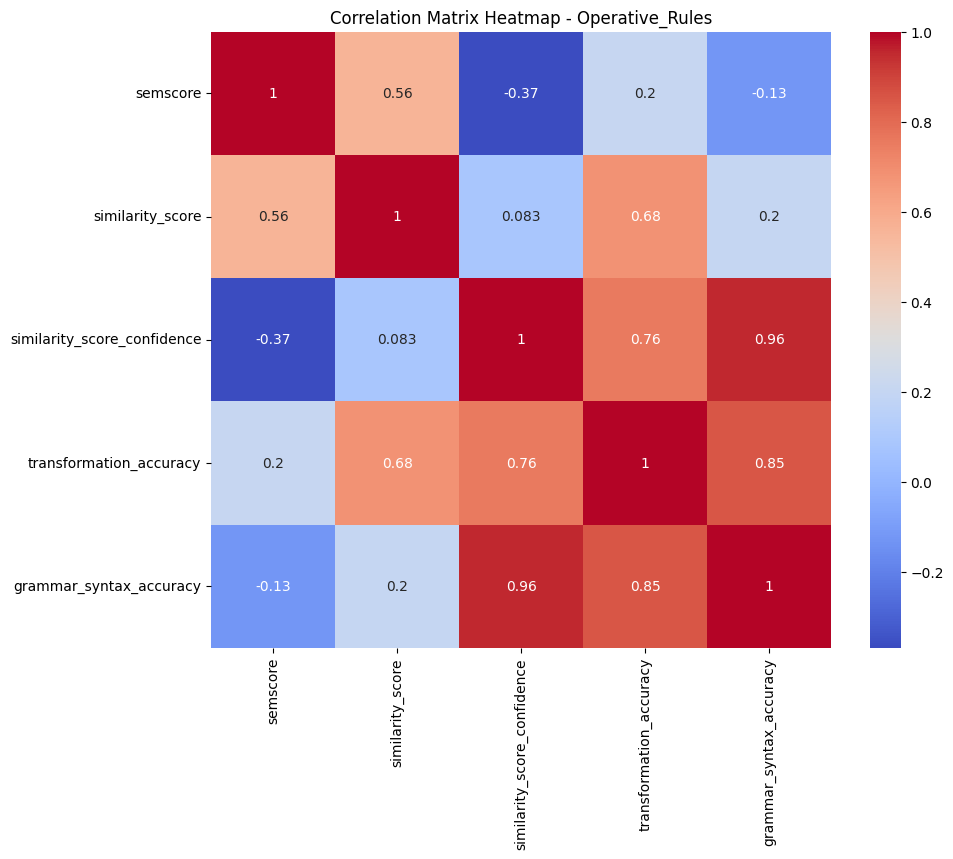

2024-11-30 18:49:26 - INFO - 
Processing Element Type: Names


Semscore Statistics:


semscore
count  5.000000
mean   0.801724
std    0.062090
min    0.701391
25%    0.785703
50%    0.820769
75%    0.850252
max    0.850504
range  0.149113
IQR    0.064549


Similarity Score Statistics:


similarity_score
count          5.000000
mean           0.940000
std            0.022361
min            0.900000
25%            0.950000
50%            0.950000
75%            0.950000
max            0.950000
range          0.050000
IQR            0.000000

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.




Pearson Correlation between semscore and similarity_score: 0.1442
Spearman Correlation between semscore and similarity_score: 0.3536

Intraclass Correlation Coefficient (ICC) between semscore and similarity_score: 0.0287


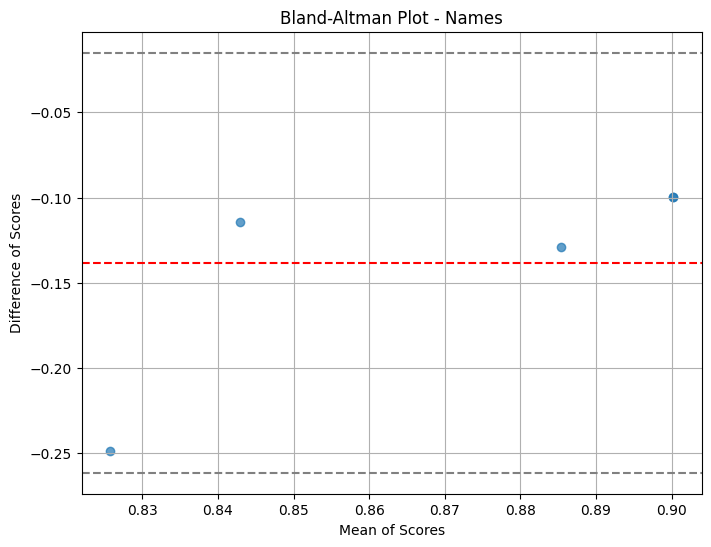

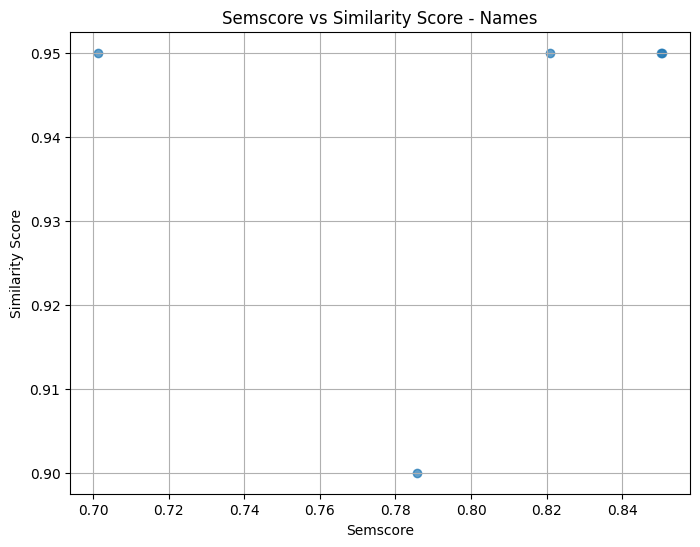

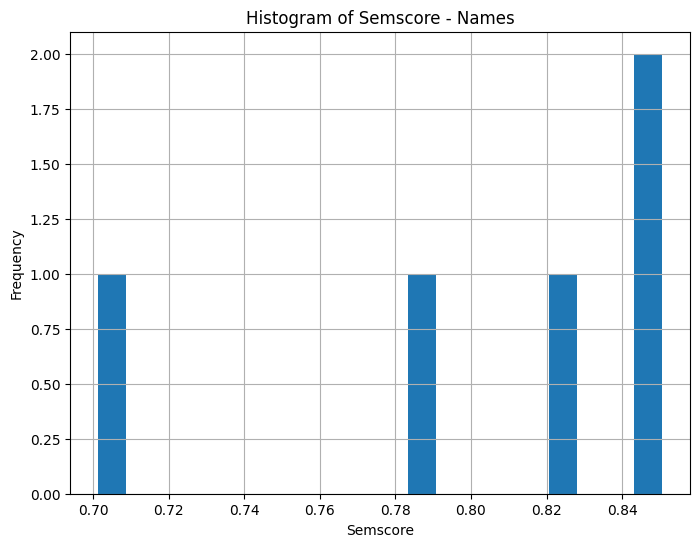

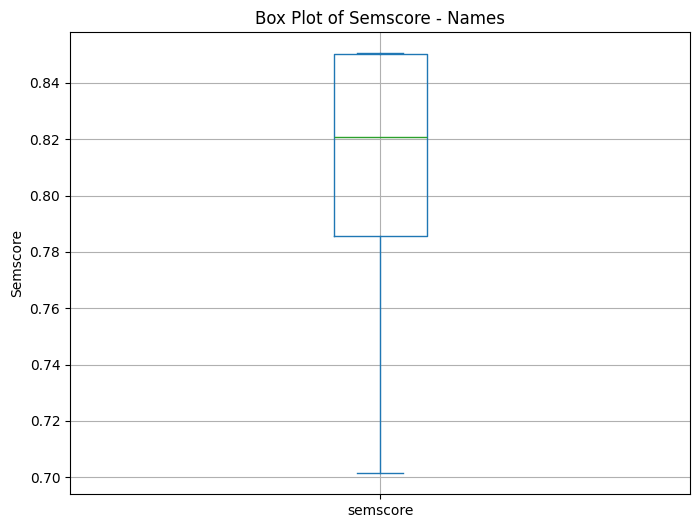

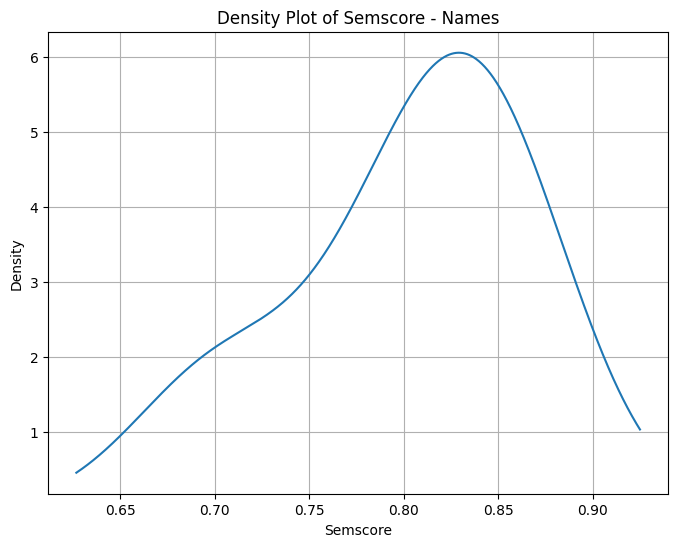


Count of Transformation Accuracy scores above 0.8: 5


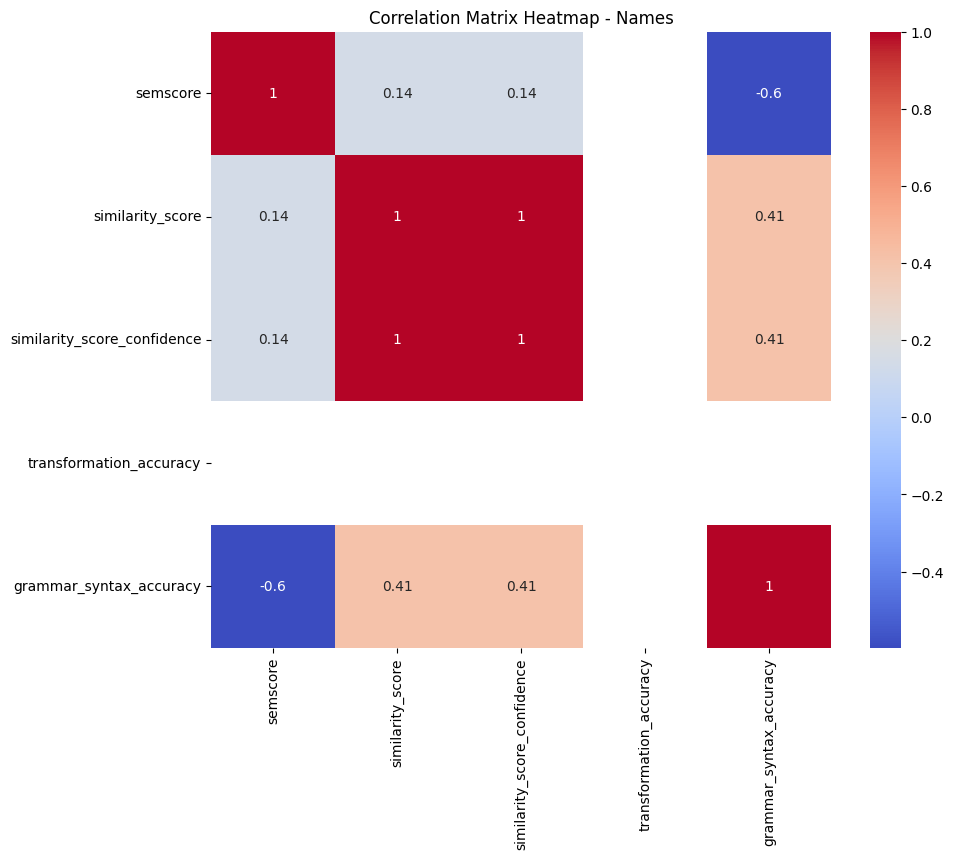

2024-11-30 18:49:27 - INFO - 
Processing Element Type: Terms


Semscore Statistics:


semscore
count  23.000000
mean    0.817524
std     0.084376
min     0.655024
25%     0.757786
50%     0.795322
75%     0.888482
max     0.950736
range   0.295712
IQR     0.130696


Similarity Score Statistics:


similarity_score
count         23.000000
mean           0.913043
std            0.062554
min            0.700000
25%            0.900000
50%            0.950000
75%            0.950000
max            0.950000
range          0.250000
IQR            0.050000


Pearson Correlation between semscore and similarity_score: -0.2628
Spearman Correlation between semscore and similarity_score: -0.1876


/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with cg




Intraclass Correlation Coefficient (ICC) between semscore and similarity_score: 0.0589


/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning:

MixedLM optimization failed, trying a different optimizer may help.

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning:

Gradient optimization failed, |grad| = 4.998316

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter valu

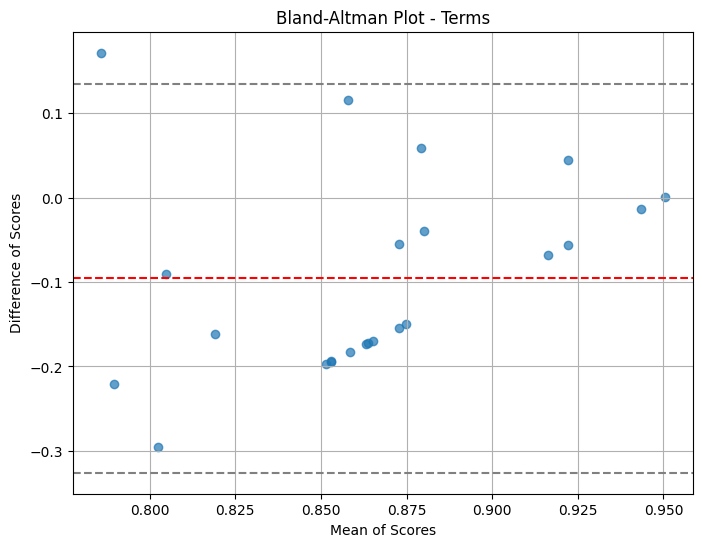

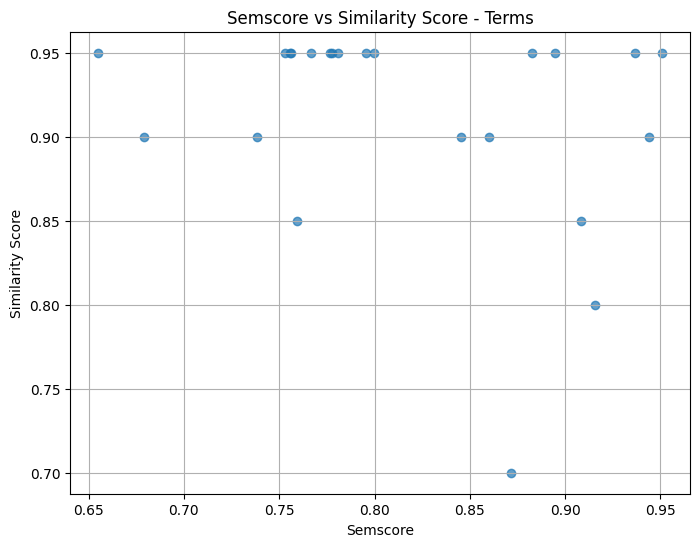

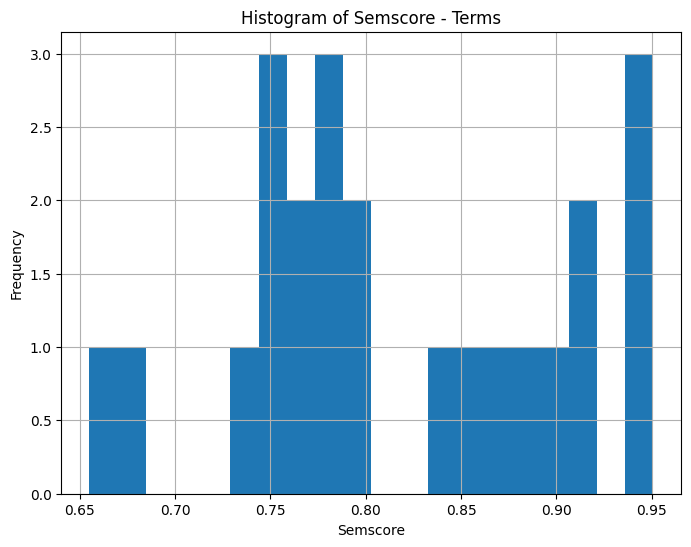

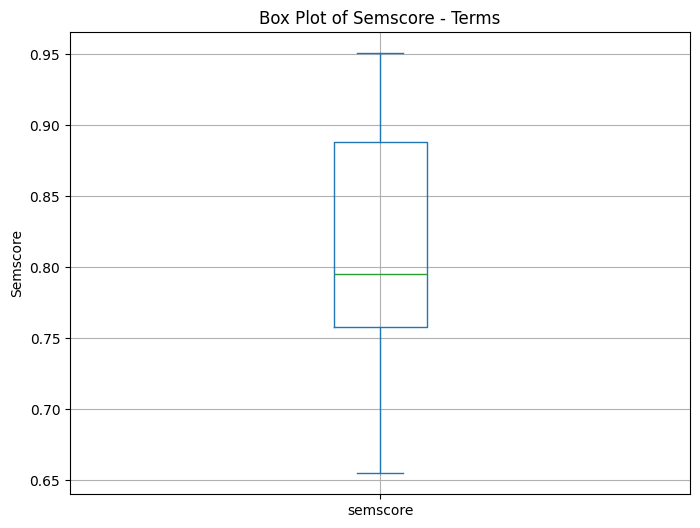

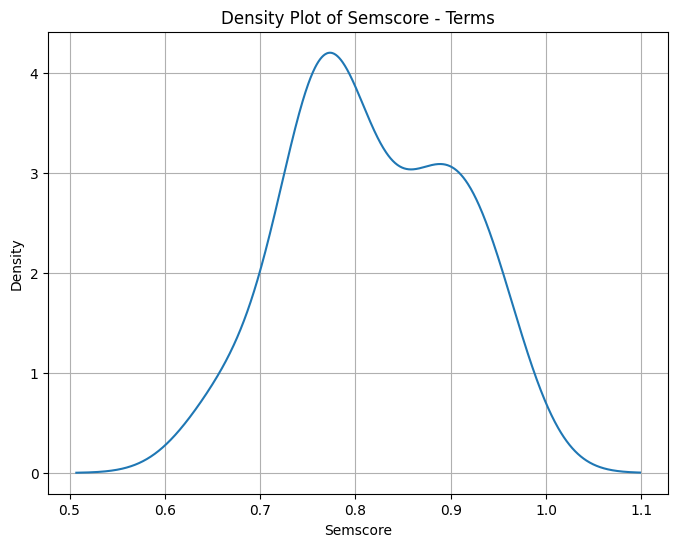


Count of Transformation Accuracy scores above 0.8: 16


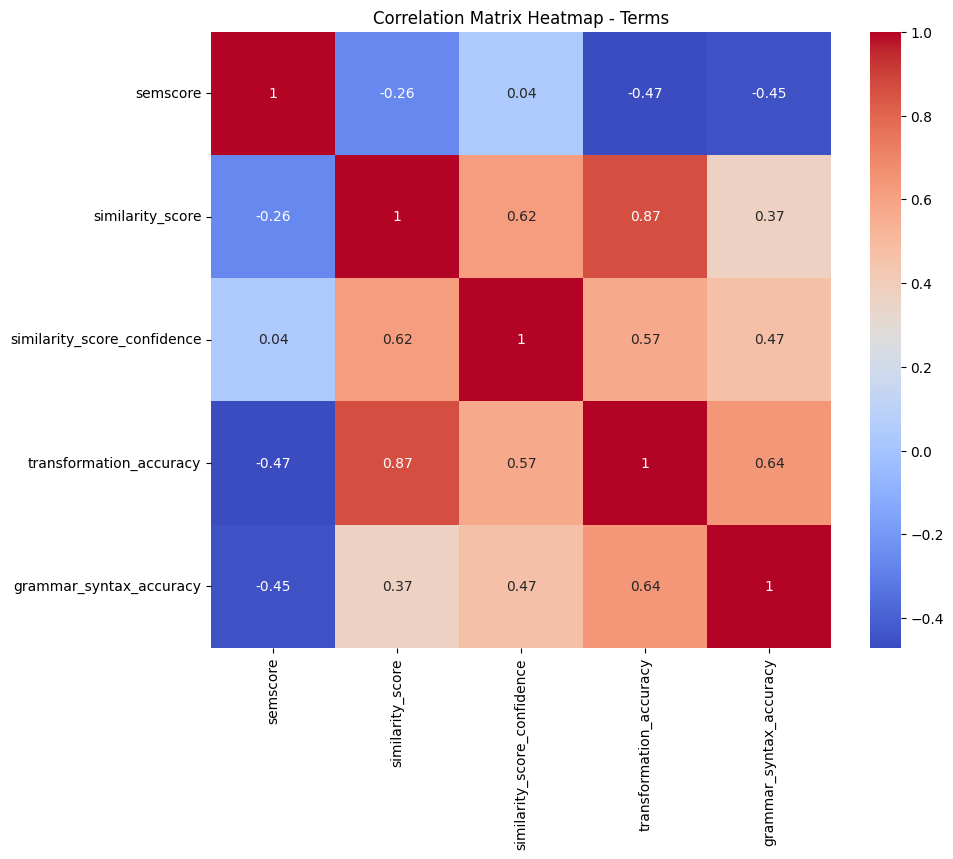

2024-11-30 18:49:29 - INFO - 
Processing Element Type: Fact_Types


Semscore Statistics:


semscore
count  16.000000
mean    0.873393
std     0.104257
min     0.571214
25%     0.844955
50%     0.911187
75%     0.938971
max     0.977909
range   0.406695
IQR     0.094016


Similarity Score Statistics:


similarity_score
count          16.00000
mean            0.87500
std             0.17127
min             0.30000
25%             0.91250
50%             0.95000
75%             0.95000
max             0.95000
range           0.65000
IQR             0.03750


Pearson Correlation between semscore and similarity_score: 0.7663
Spearman Correlation between semscore and similarity_score: 0.4546

Intraclass Correlation Coefficient (ICC) between semscore and similarity_score: 0.6976


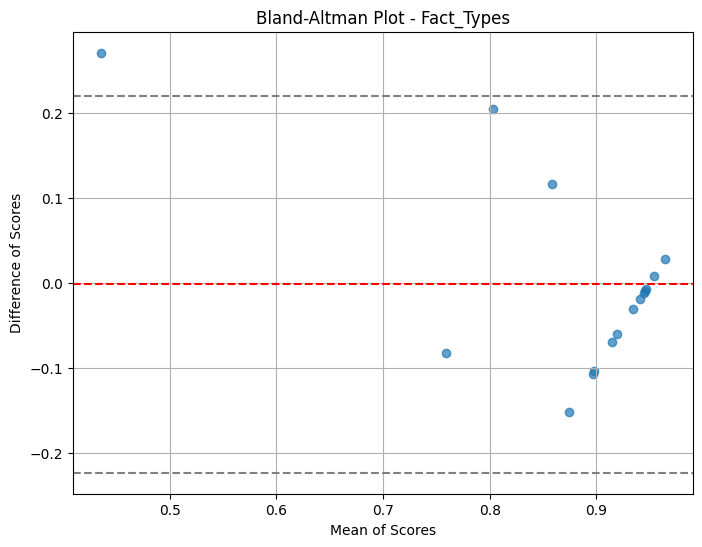

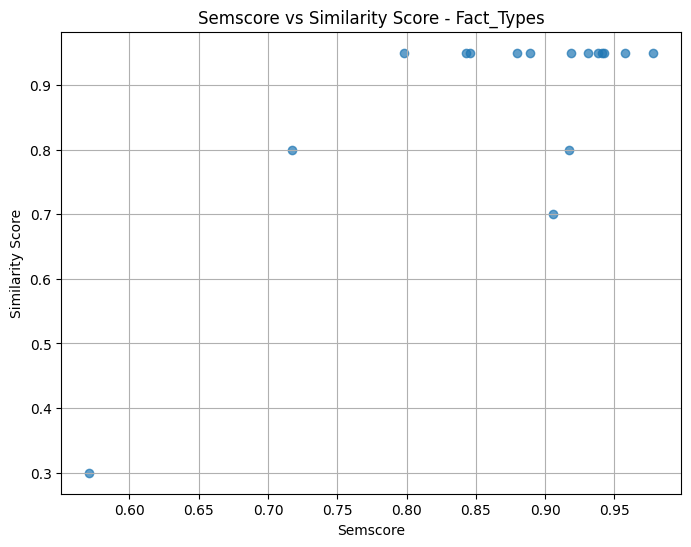

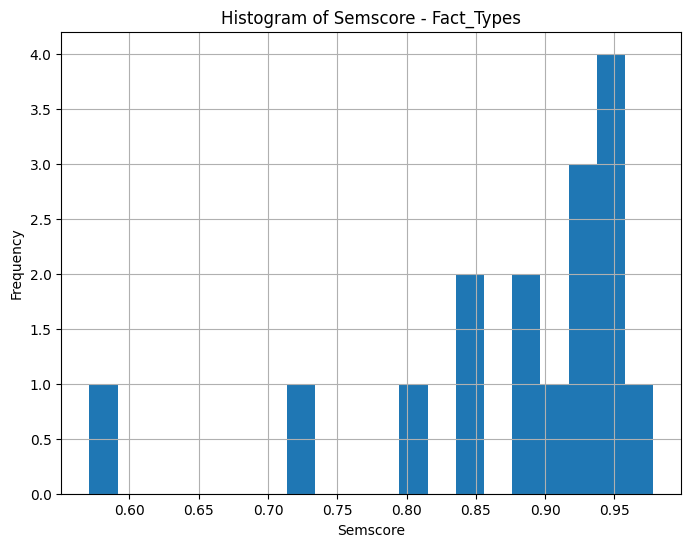

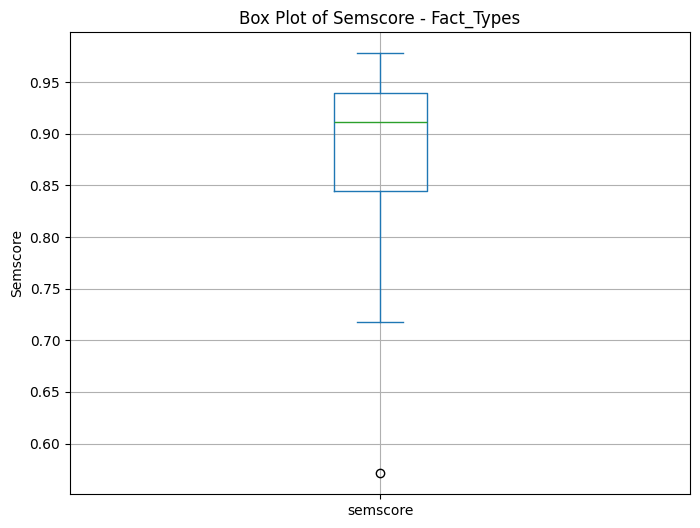

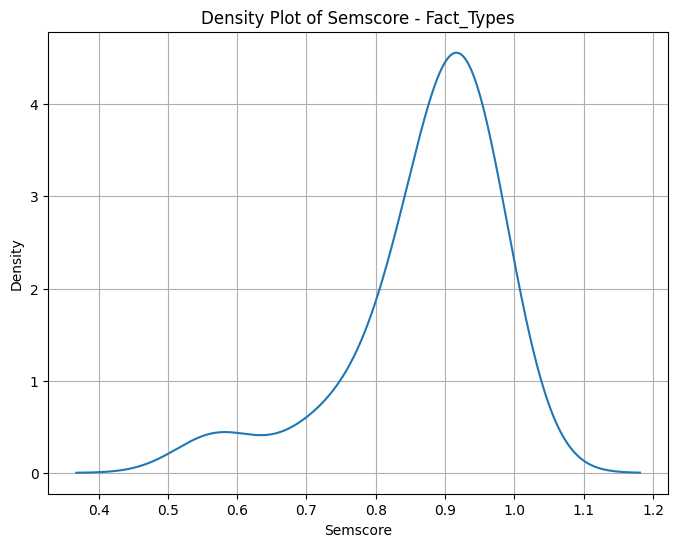


Count of Transformation Accuracy scores above 0.8: 12


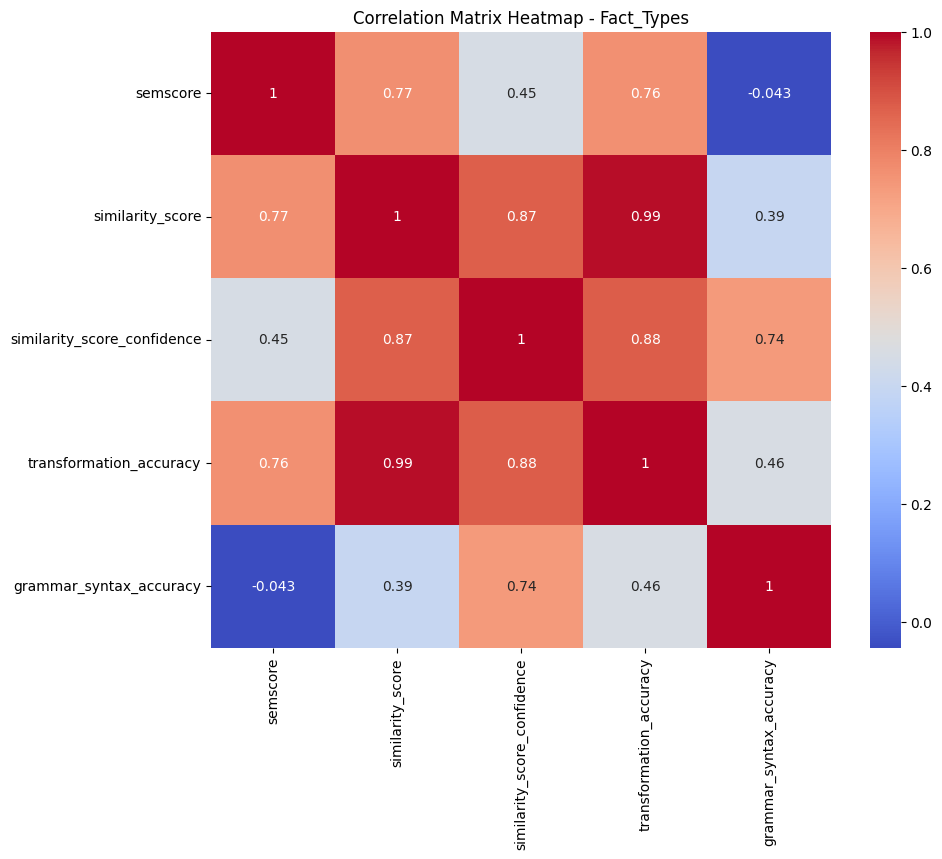


Processing Combined Data
Combined Semscore Statistics:


semscore
count  50.000000
mean    0.848283
std     0.093663
min     0.571214
25%     0.778337
50%     0.865933
75%     0.926408
max     0.977909
range   0.406695
IQR     0.148071


Combined Similarity Score Statistics:


similarity_score
count           50.0000
mean             0.9030
std              0.1071
min              0.3000
25%              0.9000
50%              0.9500
75%              0.9500
max              0.9500
range            0.6500
IQR              0.0500


Combined Pearson Correlation between semscore and similarity_score: 0.3157
Combined Spearman Correlation between semscore and similarity_score: 0.0839

Combined Intraclass Correlation Coefficient (ICC) between semscore and similarity_score: 0.2304


/home/adsantos/miniconda3/envs/ipt-cfr2sbvr/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



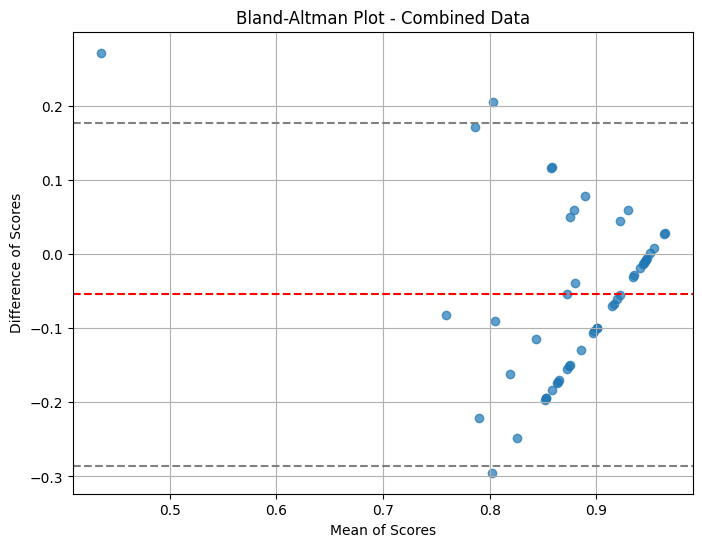

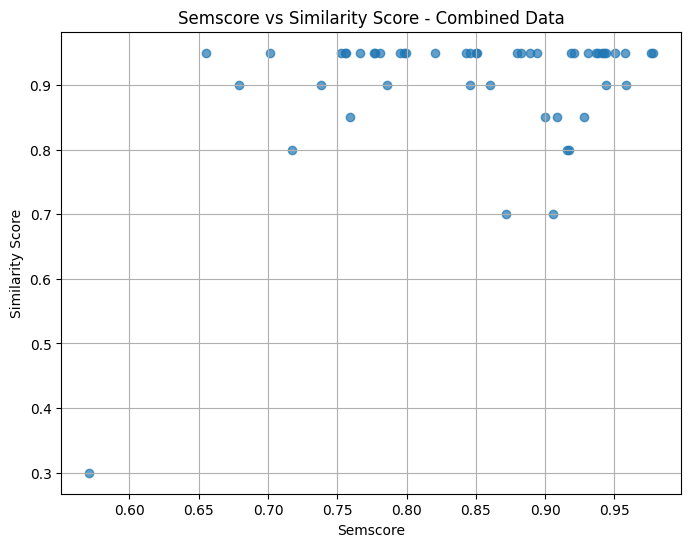

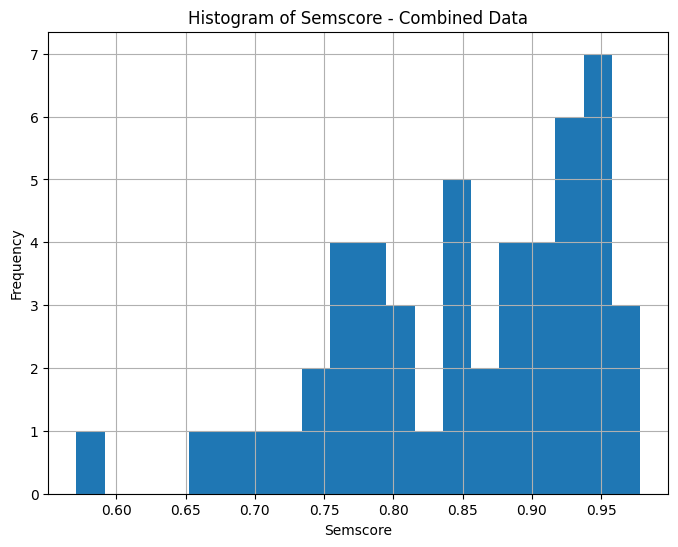

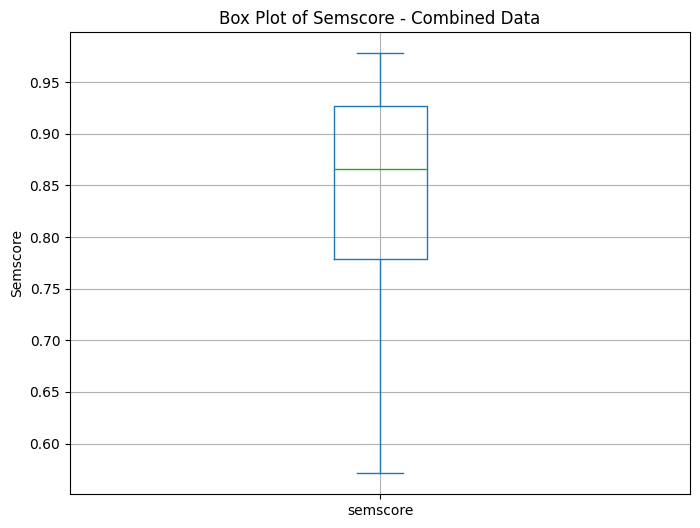

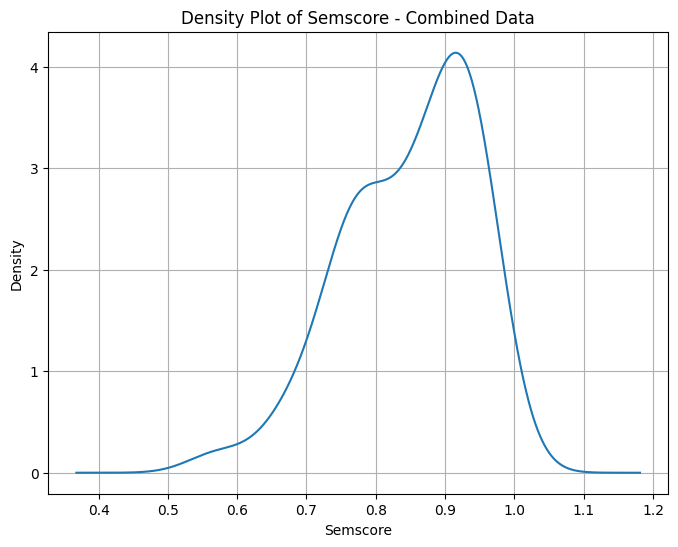


Combined Count of Transformation Accuracy scores above 0.8: 36


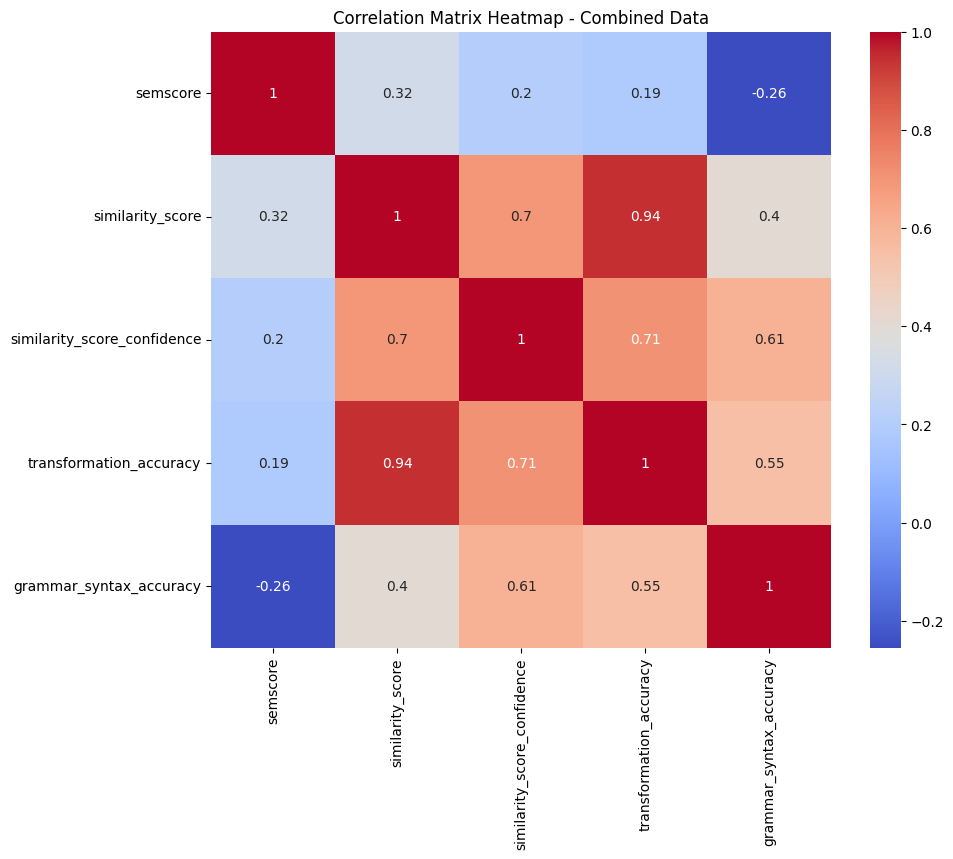

Analysis saved to '../outputs/combined_analysis_results.xlsx'


In [93]:
manager = restore_checkpoint(filename=config["DEFAULT_CHECKPOINT_FILE"])

elements_data = {
    'Operative_Rules': manager.retrieve_document("validation_judge_Operative_Rules", "llm_validation").content,
    'Names': manager.retrieve_document("validation_judge_Names", "llm_validation").content,
    'Terms': manager.retrieve_document("validation_judge_Terms", "llm_validation").content,
    'Fact_Types': manager.retrieve_document("validation_judge_Fact_Types", "llm_validation").content,
}

process_all_elements(elements_data, config["DEFAULT_OUTPUT_DIR"])

### Prompt analysis

Analyze number of tokens from prompts and documents from last checkpoint using gpt-4o as a reference model.

According to [OpenAI | models](https://platform.openai.com/docs/models), the maximum number of tokens (context length) for gpt-4o is 128k.

The cost to use gpt-4o is 2.50 USD per 1m tokens in 2024-10-31. Source: [OpenAI | pricing](https://openai.com/pricing).

Extract elapse times and completions from all sessions.

In [94]:
managers, file_info_list = get_all_checkpoints(config["DEFAULT_CHECKPOINT_DIR"])

2024-11-30 18:49:31 - INFO - DocumentManager restored from file: ../data/checkpoints/documents-2024-11-29-4.json


In [95]:
tokens_eval = {"doc_type": [], "elapsed_times": [], "completions": []}

for manager, file_info in zip(managers, file_info_list):
    # Process documents
    for key in manager.model_dump()["documents"].keys():
        if key[1].startswith("llm_"):
            doc = manager.retrieve_document(key[0], key[1])
            logger.info(f"Processing: {key[0]}, {key[1]}")
            elapsed_times = doc.elapsed_times
            logger.debug(f"Elapsed time: {elapsed_times}")
            completions = doc.completions
            logger.debug(f"Completions: {completions}")
            tokens_eval["doc_type"].append(key[1])
            tokens_eval["elapsed_times"].append(elapsed_times)
            tokens_eval["completions"].append(completions)
logger.info(f"Executions for evaluation: {len(tokens_eval['doc_type'])}")

2024-11-30 18:49:31 - INFO - Processing: § 275.0-2_P1, llm_response
2024-11-30 18:49:31 - INFO - Processing: § 275.0-2_P2, llm_response
2024-11-30 18:49:31 - INFO - Processing: § 275.0-5_P1, llm_response
2024-11-30 18:49:31 - INFO - Processing: § 275.0-5_P2, llm_response
2024-11-30 18:49:31 - INFO - Processing: § 275.0-7_P1, llm_response
2024-11-30 18:49:31 - INFO - Processing: § 275.0-7_P2, llm_response
2024-11-30 18:49:31 - INFO - Processing: classify_P1, llm_response_classification
2024-11-30 18:49:31 - INFO - Processing: classify_P2_Operative_rules, llm_response_classification
2024-11-30 18:49:31 - INFO - Processing: classify_P2_Definitional_terms, llm_response_classification
2024-11-30 18:49:31 - INFO - Processing: classify_P2_Definitional_names, llm_response_classification
2024-11-30 18:49:31 - INFO - Processing: classify_P2_Definitional_facts, llm_response_classification
2024-11-30 18:49:31 - INFO - Processing: transform_Operative_Rules, llm_response_transform
2024-11-30 18:49:3

Evaluate

In [124]:
# Constants
reference_models = config["REFERENCE_MODELS"]["MAX_CONTEXT_LENGTH"]
price_per_million_tokens = config["REFERENCE_MODELS"]["PRICE_PER_MILLION_TOKENS"]

# Initialize an empty list to store the raw data
raw_data = []

# Assuming tokens_eval is already defined and contains the necessary data
for doc_type, elapsed_times, completions in zip(tokens_eval["doc_type"], tokens_eval["elapsed_times"], tokens_eval["completions"]):
    for elapsed_time, completion in zip(elapsed_times, completions):
        raw_data.append((file_info["filename"], doc_type, elapsed_time, completion["usage"], completion["created"], completion["model"]))

prompt_analysis(raw_data, config["DEFAULT_OUTPUT_DIR"])


Overall Statistics:
 Total Tokens  Number of Samples  Average Elapsed Time (s)  Estimated Cost (USD)  Average Percentage of Context Length (%) Min Created Timestamp Max Created Timestamp                      origin              run_at
       551635                114                  4.518544              1.379088                                  3.780393   2024-11-30 00:08:20   2024-11-30 21:49:21 documents-2024-11-29-4.json 2024-11-30 19:27:02

Statistics by Sample Type (doc_type):
                   doc_type  total_tokens  num_samples  average_elapsed_time  average_tokens  estimated_cost  average_percentage_context_length                    filename              run_at
               llm_response         27285            6             28.951583        4547.500        0.068212                           3.552734 documents-2024-11-29-4.json 2024-11-30 19:27:02
llm_response_classification         66159            8             13.964686        8269.875        0.165397                  

## References

- [Scikit-LLM: Scikit-Learn Meets Large Language Models](https://medium.com/@sayedebad.777/scikit-llm-scikit-learn-meets-large-language-models-986ff149abcc)
- [23 Game-Changing Python Packages You Are Missing Out On](https://medium.com/pythoneers/23-underrated-python-packages-you-didnt-knew-existed-36dbb0a417c0) - 19 Jellyfish
- [Embeddings are underrated](https://technicalwriting.dev/data/embeddings.html)
- [You Should Probably Pay Attention to Tokenizers](https://cybernetist.com/2024/10/21/you-should-probably-pay-attention-to-tokenizers/?utm_source=tldrnewsletter) - Embeddings